## 1. Using neural nets to recognize handwritten digits

In [1]:
# %load network.py

"""
network.py
~~~~~~~~~~

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        training_data = list(training_data)
        # n is 50000
        n = len(training_data)

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : {} / {}".format(j,self.evaluate(test_data),n_test))
            else:
                print("Epoch {} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [2]:
# %load mnist_loader.py
"""
mnist_loader
~~~~~~~~~~~~
A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [12]:
sys.path.append('./src/')
import mnist_loader
import network

training_data, validation_data, test_data = mnist_loader.load_data()
test_data

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([7, 2, 1, ..., 4, 5, 6]))

In [16]:
test_data[1]

array([7, 2, 1, ..., 4, 5, 6])

In [36]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
test_data

In [37]:
# list() can open the zip, 50000 samples in training_data, each sample is a tuple, which has 2 arrays of size (784,1) and (10, 1)
list(training_data)[0][1]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [5]:
net = network.Network([784, 30, 10])

In [6]:
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0 : 8984 / 10000
Epoch 1 : 9213 / 10000
Epoch 2 : 9262 / 10000
Epoch 3 : 9343 / 10000
Epoch 4 : 9375 / 10000
Epoch 5 : 9384 / 10000
Epoch 6 : 9435 / 10000
Epoch 7 : 9421 / 10000
Epoch 8 : 9451 / 10000
Epoch 9 : 9465 / 10000
Epoch 10 : 9457 / 10000
Epoch 11 : 9437 / 10000
Epoch 12 : 9486 / 10000
Epoch 13 : 9495 / 10000
Epoch 14 : 9489 / 10000
Epoch 15 : 9513 / 10000
Epoch 16 : 9466 / 10000
Epoch 17 : 9486 / 10000
Epoch 18 : 9504 / 10000
Epoch 19 : 9499 / 10000
Epoch 20 : 9517 / 10000
Epoch 21 : 9490 / 10000
Epoch 22 : 9508 / 10000
Epoch 23 : 9505 / 10000
Epoch 24 : 9520 / 10000
Epoch 25 : 9522 / 10000
Epoch 26 : 9509 / 10000
Epoch 27 : 9531 / 10000
Epoch 28 : 9502 / 10000
Epoch 29 : 9508 / 10000


In [9]:
#Let's rerun the above experiment, changing the number of hidden neurons to 100
net = network.Network([784, 100, 10])
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0 : 5880 / 10000
Epoch 1 : 5941 / 10000
Epoch 2 : 5967 / 10000
Epoch 3 : 6063 / 10000
Epoch 4 : 6898 / 10000
Epoch 5 : 7635 / 10000
Epoch 6 : 7706 / 10000
Epoch 7 : 7752 / 10000
Epoch 8 : 7762 / 10000
Epoch 9 : 7766 / 10000
Epoch 10 : 7794 / 10000
Epoch 11 : 7787 / 10000
Epoch 12 : 7783 / 10000
Epoch 13 : 7791 / 10000
Epoch 14 : 7804 / 10000
Epoch 15 : 7802 / 10000
Epoch 16 : 7815 / 10000
Epoch 17 : 7827 / 10000
Epoch 18 : 7813 / 10000
Epoch 19 : 7819 / 10000
Epoch 20 : 7814 / 10000
Epoch 21 : 7805 / 10000
Epoch 22 : 7825 / 10000
Epoch 23 : 7815 / 10000
Epoch 24 : 7820 / 10000
Epoch 25 : 7822 / 10000
Epoch 26 : 7821 / 10000
Epoch 27 : 7823 / 10000
Epoch 28 : 7824 / 10000
Epoch 29 : 7820 / 10000


In [11]:
#Let's rerun the above experiment, changing the number of hidden neurons to 0
net = network.Network([784, 0, 10])
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0 : 1010 / 10000
Epoch 1 : 974 / 10000
Epoch 2 : 1032 / 10000
Epoch 3 : 1135 / 10000
Epoch 4 : 1009 / 10000
Epoch 5 : 1135 / 10000
Epoch 6 : 1135 / 10000
Epoch 7 : 1135 / 10000
Epoch 8 : 980 / 10000
Epoch 9 : 1032 / 10000
Epoch 10 : 1009 / 10000
Epoch 11 : 1135 / 10000
Epoch 12 : 1135 / 10000
Epoch 13 : 980 / 10000
Epoch 14 : 1135 / 10000
Epoch 15 : 1009 / 10000
Epoch 16 : 1032 / 10000
Epoch 17 : 980 / 10000
Epoch 18 : 1135 / 10000
Epoch 19 : 1010 / 10000
Epoch 20 : 1135 / 10000
Epoch 21 : 1135 / 10000
Epoch 22 : 1135 / 10000
Epoch 23 : 1009 / 10000
Epoch 24 : 1135 / 10000
Epoch 25 : 1135 / 10000
Epoch 26 : 1135 / 10000
Epoch 27 : 1135 / 10000
Epoch 28 : 1032 / 10000
Epoch 29 : 1135 / 10000


In [38]:
"""
mnist_average_darkness
~~~~~~~~~~~~~~~~~~~~~~

A naive classifier for recognizing handwritten digits from the MNIST
data set.  The program classifies digits based on how dark they are
--- the idea is that digits like "1" tend to be less dark than digits
like "8", simply because the latter has a more complex shape.  When
shown an image the classifier returns whichever digit in the training
data had the closest average darkness.

The program works in two steps: first it trains the classifier, and
then it applies the classifier to the MNIST test data to see how many
digits are correctly classified.

Needless to say, this isn't a very good way of recognizing handwritten
digits!  Still, it's useful to show what sort of performance we get
from naive ideas."""

#### Libraries
# Standard library
from collections import defaultdict

# My libraries
import mnist_loader

def main():
    training_data, validation_data, test_data = mnist_loader.load_data()
    # training phase: compute the average darknesses for each digit,
    # based on the training data
    avgs = avg_darknesses(training_data)
    # testing phase: see how many of the test images are classified
    # correctly
    num_correct = sum(int(guess_digit(image, avgs) == digit)
                      for image, digit in zip(test_data[0], test_data[1]))
    print("Baseline classifier using average darkness of image.")
    print("{0} of {1} values correct.".format(num_correct, len(test_data[1])))

def avg_darknesses(training_data):
    """ Return a defaultdict whose keys are the digits 0 through 9.
    For each digit we compute a value which is the average darkness of
    training images containing that digit.  The darkness for any
    particular image is just the sum of the darknesses for each pixel."""
    digit_counts = defaultdict(int)
    darknesses = defaultdict(float)
    for image, digit in zip(training_data[0], training_data[1]):
        digit_counts[digit] += 1
        darknesses[digit] += sum(image)
    avgs = defaultdict(float)
    for digit, n in digit_counts.items():
        avgs[digit] = darknesses[digit] / n
    return avgs

def guess_digit(image, avgs):
    """Return the digit whose average darkness in the training data is
    closest to the darkness of ``image``.  Note that ``avgs`` is
    assumed to be a defaultdict whose keys are 0...9, and whose values
    are the corresponding average darknesses across the training data."""
    darkness = sum(image)
    distances = {k: abs(v-darkness) for k, v in avgs.items()}
    return min(distances, key=distances.get)

if __name__ == "__main__":
    main()

Baseline classifier using average darkness of image.
2225 of 10000 values correct.


In [42]:
#sys.path.append('./src/')
import mnist_average_darkness
mnist_average_darkness.main()

Baseline classifier using average darkness of image.
2225 of 10000 values correct.


In [43]:
"""
mnist_svm
~~~~~~~~~

A classifier program for recognizing handwritten digits from the MNIST
data set, using an SVM classifier."""

#### Libraries
# My libraries
import mnist_loader 

# Third-party libraries
from sklearn import svm

def svm_baseline():
    training_data, validation_data, test_data = mnist_loader.load_data()
    # train
    clf = svm.SVC()
    clf.fit(training_data[0], training_data[1])
    # test
    predictions = [int(a) for a in clf.predict(test_data[0])]
    num_correct = sum(int(a == y) for a, y in zip(predictions, test_data[1]))
    print("Baseline classifier using an SVM.")
    print(str(num_correct) + " of " + str(len(test_data[1])) + " values correct.")

if __name__ == "__main__":
    svm_baseline()

Baseline classifier using an SVM.
9785 of 10000 values correct.


In [44]:
#sys.path.append('./src/')
import mnist_svm
mnist_svm.svm_baseline()

Baseline classifier using an SVM.
9785 of 10000 values correct.


## 2. How the backpropagation algorithm works

We’ll use $w_{jk}^l$ to denote the weight for the connection from the $k$-th neuron in the ($l-1$)-th layer to the $j$-th neuron in the $l$-th layer.

![weight_matrix.png](fig/weight_matrix.png)

We use $b_j^l$ for the bias of the $j$-th neuron in the $l$-th layer. And we use $a_j^l$ for the activation of the $j$-th neuron in the $l$-th layer.

![layers](fig/layers.png)


$$a_j^l=\sigma\left(\sum_{k}w_{jk}^la_k^{l-1}+b_j^l\right),\tag{2.1}$$


where the sum is over all neurons $k$ in the ($l-1$)-th layer.

Equation 2.1 can be rewritten in the beautiful and compact
vectorized form
$$a^l=\sigma\left(w^la_k^{l-1}+b_j^l\right).\tag{2.3}$$ 

We compute the intermediate quantity 
$$z_j^l\equiv \sum_{k}w_{jk}^la_k^{l-1}+b_j^l$$
$$z^l\equiv w^l a^{l-1}+b^l$$

along the way. This quantity turns out to be useful enough to be worth naming:
we call $z^l$ the **weighted input** to the neurons in layer $l$. We’ll make considerable use of the weighted input $z^l$ later in the chapter.

The quadratic cost has the form $$C=\frac{1}{2n}\sum_{x}\left\lVert y(x)-a^L(x)\right\rVert^2,\tag{2.4}$$ 
where: $n$ is the total number of training examples; the sum is over individual training examples, $x$; $y = y(x)$ is the corresponding desired output; $L$ denotes the number of layers in the network; and $a^L = a^L(x)$ is the vector of activations output from the network when $x$ is input.

$Backpropagation$ is about understanding how changing the weights and biases in a network changes the cost function. Ultimately, this means computing the partial derivatives $\partial C/\partial w_{jk}^l$ and $\partial C/\partial b_j^l$. But to compute those, we first introduce an intermediate quantity, $\delta_j^l$, which
we call the $error$ in the $j$-th neuron in the $l$-th layer. Backpropagation will give us a procedure to compute the error $\delta_j^l$, and then will relate $\delta_j^l$ to $\partial C/\partial w_{jk}^l$ and $\partial C/\partial b_j^l$.  

To understand how the error is defined, imagine there is a demon in our neural network: The demon sits at the j-th neuron in layer $l$. As the input to the neuron comes in, the demon messes with the neuron’s operation. It adds a little change $\Delta z_j^l$ to the neuron’s weighted input, so that instead of outputting $\sigma(z_j^l)$, the neuron instead outputs $\sigma(z_j^l+\Delta z_j^l)$. This change propagates through later layers in the network, causing the overall cost to change by an amount $$\frac{\partial C}{\partial z_j^l}\Delta z_j^l.$$ 

We define the error $\delta_j^l$ of neuron $j$ in layer $l$ by $$\delta_j^l\equiv\frac{\partial C}{\partial z_j^l}, \tag{2.7}$$ 

We use $\delta^l$ to denote the vector of errors associated with layer $l$. Backpropagation will give us a way of computing $\delta^l$ for every layer, and then relating those errors to the quantities of real interest, $\partial C/\partial w_{jk}^l$ and $\partial C/\partial b_{j}^l$.

**An equation for the error in the output layer**, $\delta^L$: The components of $\delta^L$ are given by: 
$$\begin{equation}
\delta_j^L=\frac{\partial C}{\partial a_j^L}\sigma'(z_j^L)\tag{BP1}\label{BP1}
\end{equation}$$

If we’re using the quadratic cost function then $$C = \frac{1}{2}\sum_{j}(y_j-a_j^L)^2,$$ and 
and so $$\frac{\partial C}{\partial a_j^L}=(a_j^L-y_j)$$ which obviously is easily computable. 
It’s easy to rewrite the (\ref{BP1}) equation in a matrix-based form, as 
$$\begin{equation}
\delta^L=\nabla_a C\cdot\sigma'(z^L)\tag{BP1a}\label{BP1a}
\end{equation}$$  

**Proof**
By definition $$\delta_j^L=\frac{\partial C}{\partial z_j^L}$$ then 
$$\delta_j^L=\sum_k\frac{\partial C}{\partial a_k^L}\frac{\partial a_k^L}{\partial z_j^L},$$ where the sum is over all neurons $k$ in the output layer.. 

The output activation $a_k^L$ of the $k$-th neuron depends only on the weighted input $z_j^L$ for the $j$-th neuron when $k = j$. And so $\frac{\partial a_k^L}{\partial z_j^L}$ vanishes when $k \ne j$. As a result we can simplify the previous equation to $$\delta_j^L=\frac{\partial C}{\partial a_j^L}\frac{\partial a_j^L}{\partial z_j^L},$$ Recalling that $a^L_j=\sigma(z_j^L)$ the second term on the right can be written as $\sigma'(z_j^L)$, and the equation becomes $$\delta_j^L=\frac{\partial C}{\partial a_j^L}\sigma'(z_j^L),\tag{2.17}$$ which is just (\ref{BP1}).

**An equation for the error $\delta^l$ in terms of the error in the next layer, $\delta^{l+1}$**: In particular
$$\begin{equation}
\delta^l=((w^{l+1})^T\delta^{l+1})\cdot\sigma'(z^l)\tag{BP2}\label{BP2}
\end{equation}$$  
When we apply the transpose weight matrix, $(w^{l+1})^T$ , we can think intuitively of this as moving the error backward through the network, giving us
some sort of measure of the error at the output of the $l$-th layer. We then take the Hadamard product $\cdot\sigma'(z^l)$. This moves the error backward through the activation function in layer $l$, giving us the error $\delta^l$ in the weighted input to layer $l$.  

By combining (\ref{BP1}) with (\ref{BP2}) we can compute the error $\delta^l$ for any layer in the network. We start by using (\ref{BP1}) to compute $\delta^L$, then apply Equation (\ref{BP2}) to compute $\delta^{L-1}$, then
Equation (\ref{BP2}) again to compute $\delta^{L-2}$, and so on, all the way back through the network.  

**Proof** 
(\ref{BP2}), the error $\delta^l$ in terms of the error in the next layer, $\delta^{l+1}$. To do this, we want to rewrite $\delta_j^l=\partial C/\partial z_j^l$ in terms of $\delta_k^{l+1}=\partial C/\partial z_k^{l+1}$. We can do this using the chain rule, $$\delta_j^l=\frac{\partial C}{\partial z_j^l}=\sum_k\frac{\partial C}{\partial z_k^{l+1}}\frac{\partial z_k^{l+1}}{\partial z_j^l}=\sum_k\frac{\partial z_k^{l+1}}{\partial z_j^l}\delta_k^{l+1}\tag{2.18}$$
To evaluate the first term on the last line, note that $$z_k^{l+1}=\sum_{j}w_{kj}^{l+1}a_j^l+b_k^{l+1}=\sum_j w_{kj}^{l+1}\sigma(z_j^l)+b_k^{l+1}\tag{2.19}$$
Differentiating, we obtain
$$\frac{\partial z_k^{l+1}}{\partial z_j^{l}}=w_{kj}^{l+1}\sigma'(z_j^l)\tag{2.20}$$ 
Substituting back into (2.18) we obtain $$\delta_j^l=\sum_k w_{kj}^{l+1}\delta_k^{l+1}\sigma'(z_j^l).\tag{2.21}$$
This is just (\ref{BP2}) written in component form.

**An equation for the rate of change of the cost with respect to any bias in the network**: In particular:
$$\begin{equation}
\frac{\partial C}{\partial b_j^l}=\delta_j^l\tag{BP3}\label{BP3}
\end{equation}$$ Since (\ref{BP1}) and (\ref{BP2}) have already told us how to compute $\delta_j^l$. We can rewrite (\ref{BP3}) in shorthand as 
$$\frac{\partial C}{\partial b}=\delta\tag{2.9}$$ 
where it is understood that $\delta$ is being evaluated at the same neuron as the bias $b$.  

**An equation for the rate of change of the cost with respect to any weight in the network**: In particular: 
$$\begin{equation}
\frac{\partial C}{\partial w_{jk}^l}=a_k^{l-1}\delta_j^l\tag{BP4}\label{BP4}
\end{equation}$$ 
This tells us how to compute the partial derivatives $\frac{\partial C}{\partial w_{jk}^l}$ in terms of the quantities $\delta^l$ and $a^{l-1}$, which we already know how to compute. The equation can be rewritten in a less index-heavy notation as $$\frac{\partial C}{\partial w}=a_{in}\delta_{out},\tag{2.10}$$
where it’s understood that $a_{in}$ is the activation of the neuron input to the weight $w$, and $\delta_{out}$ is the error of the neuron output from the weight $w$.  

Consider the term $\sigma'(z_j^L)$ in (\ref{BP1}). Recall from the graph
of the sigmoid function in the last chapter that the $\sigma$ function becomes very flat when $\sigma(z_j^L)$ is approximately $0$ or $1$. When this occurs we will have $\sigma'(z_j^L)\approx 0$. And so the lesson is that a weight in the final layer will learn slowly if the output neuron is either low activation $(\approx 0)$ or high activation $(\approx 1)$. In this case it’s common to say the output neuron has **saturated** and, as a result, the weight has stopped learning (or is learning slowly). Similar remarks hold also for the biases of output neuron. 

We can obtain similar insights for earlier layers. In particular, note the $\sigma'(z^l)$ term in (\ref{BP2}). This means that $\delta_j^l$ is likely to get small if the neuron is near saturation. And this, in turn, means that any weights input to a saturated neuron will learn slowly.

**Summary: the equations of backpropagation**
$$\begin{equation}
\delta^L=\nabla_a C\cdot\sigma'(z^L)\tag{BP1}\label{BP1}
\end{equation}$$
$$\begin{equation}
\delta^l=((w^{l+1})^T\delta^{l+1})\cdot\sigma'(z^l)\tag{BP2}\label{BP2}
\end{equation}$$
$$\begin{equation}
\frac{\partial C}{\partial b_j^l}=\delta_j^l\tag{BP3}\label{BP3}
\end{equation}$$
$$\begin{equation}
\frac{\partial C}{\partial w_{jk}^l}=a_k^{l-1}\delta_j^l\tag{BP4}\label{BP4}
\end{equation}$$

(\ref{BP1}) may be rewritten as $$\delta^L=\sum'(z^L)\nabla_a C\tag{2.11}$$
where $\sum'(z^L)$ is a square matrix whose diagonal entries are the values $\sigma'(z_j^L)$, and whose off-diagonal entries are zero. Note that this matrix acts on $\nabla_a C$ by conventional matrix multiplication.  

(\ref{BP2}) may be rewritten as
$$\delta^l=\sum'(z^l)(w^{l+1})^T\cdots\sum'(z^{L-1})(w^{L})^T\sum'(z^L)\nabla_a C\tag{2.13}$$

In particular, given a mini-batch of $m$ training examples, the following algorithm applies a gradient descent learning step based on that mini-batch:
- 1. Input a set of training examples
- 2. For each training example $x$: Set the corresponding input activation $a^{x,1}$, and perform the following steps:
  - Feedforward: For each $l= 2,3, \cdots, L$ compute $z^{x,l}=w^la^{x, l-1}+b^l$ and $a^{x, l}=\sigma(z^{x,l})$.
  - Output error $\delta^{x,L}$: Compute the vector $\delta^{x,L}=\nabla_a C_x\cdot\sigma'(z^{x,L})$.
  - Backpropagate the error: For each $l = L -1, L - 2, \cdots, 2$ compute $\delta^{x,l}=((w^{l+1})^T\delta^{x,l+1})\cdot\sigma'(z^{z^{x,l}})$.
- 3. Gradient descent: For each $l = L, L-1, L-2, \cdots, 2$ update the weights according to the rule $$w^l\to w^l-\frac{\eta}{m}\sum_k\delta^{x,l}(a^{x,l-1})^T,$$ and the biases according to the rule $$b^l\to b^l-\frac{\eta}{m}\sum_x\delta^{x,l}$$

The change $\Delta C$ in the cost is related to the change $\Delta w_{jk}^l$ in the weight by the equation $$\Delta C\approx \frac{\partial C}{\partial w_{jk}^l}\Delta w_{jk}^l.\tag{2.23}$$ This suggests that a possible approach to computing $\frac{\partial C}{\partial w_{jk}^l}$ is to carefully track how a
small change in $w_{jk}^l$ propagates to cause a small change in $C$. If we can do that, being careful to express everything along the way in terms of easily computable quantities, then we should be able to compute $\frac{\partial C}{\partial w_{jk}^l}$.

## 3. Improving the way neural networks learn 

### 3.1 The sigmoid output and cross-entropy cost function


The quadratic cost function $$C=\frac{(y-a)^2}{2},\tag{3.1}$$ where $a$ is the neuron’s output when the training input $x = 1$ is used, and $y = 0$ is the
corresponding desired output. To write this more explicitly in terms of the weight and bias, recall that $a = \sigma(z)$, where $z = wx + b$. Using the chain rule to differentiate with respect to the weight and bias we get
$$\frac{\partial C}{\partial w}=(a-y)\sigma'(z)x=a\sigma'(z)x\tag{3.2}$$
$$\frac{\partial C}{\partial b}=(a-y)\sigma'(z)=a\sigma'(z)\tag{3.3}$$
Since $$\sigma'(z)=\left(\frac{1}{1+e^{-x}}\right)'=\sigma(z)(1-\sigma(z))$$ when the neuron’s output is close to $1$, the $\sigma'(z)$ gets very small and the learning slowdown.


We define the cross-entropy cost function for this neuron by 
$$C=-\frac{1}{n}\sum_x[y\ln a+(1-y)\ln(1-a)],\tag{3.4}$$ where $n$ is the total number of items of training data, the sum is over all training inputs, $x$, and $y$ is the corresponding desired output.
We substitute $a=\sigma(z)$ into (3.4), and apply the chain rule twice, obtaining:
$$\begin{align}
\frac{\partial C}{\partial w_j}&=-\frac{1}{n}\sum_x\left(\frac{y}{\sigma(z)}-\frac{1-y}{1-\sigma(z)}\right)\frac{\partial \sigma}{\partial w_j}\\
&=-\frac{1}{n}\sum_x\left(\frac{y}{\sigma(z)}-\frac{1-y}{1-\sigma(z)}\right)\sigma'(z)x_j\\
&=\frac{1}{n}\sum_x\frac{\sigma(z)-y}{\sigma(z)(1-\sigma(z))}\sigma'(z)x_j\\
&=\frac{1}{n}\sum_x(\sigma(z)-y)x_j\tag{3.5}
\end{align}$$ It tells us that the rate at which the weight learns is controlled by $(\sigma(z)-y)$, i.e., by the error in the output. 
And $$\frac{\partial C}{\partial b}=\frac{1}{n}\sum_x(\sigma(z)-y).\tag{3.8}$$
Again, this avoids the learning slowdown caused by the $\sigma'(z)$ term in the analogous equation for the quadratic cost, Equation (3.3).

It’s easy to generalize the cross-entropy to many-neuron multi-layer networks. In particular, suppose $y = y_1, y_2, \cdots$, are the desired values at the output neurons, i.e., the neurons in the final layer, while $a_1^L, a_2^L, \cdots$ are the actual output values. Then we define the cross-entropy by 
$$\sum_j\left[y_j\ln a_j^L+(1-y_i)\ln(1-a_j^L)\right].\tag{3.9}$$

For the cross-entropy cost the output error $\delta^L$ for a single training example $x$ is given by $$\delta^L=a^L-y.\tag{3.12}$$ 
The partial derivative with respect to the weights in the output layer is given by $$\frac{\partial C}{\partial w_{jk}^L}=\frac{1}{n}\sum_x(\sigma(z_j^L)-y_j)x_k^{L-1}=\frac{1}{n}\sum_x(a_j^L-y_j)a_k^{L-1}\tag{3.13}$$ 

The $\sigma'(z_j^L)$ term has vanished, and so the cross-entropy avoids the problem of learning slowdown, not just when used with a single neuron, as we saw earlier, but also in many-layer multi-neuron networks. A simple variation on this analysis holds also for the biases.
$$\frac{\partial C}{\partial b_j^L}=\frac{1}{n}\sum_x(a_j^L-y_j). \tag{3.16}$$

In [1]:
"""network2.py
~~~~~~~~~~~~~~

An improved version of network.py, implementing the stochastic
gradient descent learning algorithm for a feedforward neural network.
Improvements include the addition of the cross-entropy cost function,
regularization, and better initialization of network weights.  Note
that I have focused on making the code simple, easily readable, and
easily modifiable.  It is not optimized, and omits many desirable
features.

"""

#### Libraries
# Standard library
import json
import random
import sys

# Third-party libraries
import numpy as np


#### Define the quadratic and cross-entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)


#### Main Network class
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            early_stopping_n = 0):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """

        # early stopping functionality:
        best_accuracy=1

        n = len(training_data)

        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)

        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))

            print("Epoch %s training complete" % j)

            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))

            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    #print("Early-stopping: Best so far {}".format(best_accuracy))
                else:
                    no_accuracy_change += 1

                if (no_accuracy_change == early_stopping_n):
                    #print("Early-stopping: No accuracy change in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.

        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights) # '**' - to the power of.
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


In [2]:
#sys.path.append('./src/')
import mnist_loader
training_data , validation_data , test_data = mnist_loader.load_data_wrapper()
training_data = list(training_data)

In [3]:
#sys.path.append('./src/')
import network2
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
net.large_weight_initializer()
net.SGD(training_data , 30, 10, 0.5, evaluation_data=test_data , monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9076 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9163 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9301 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9291 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9345 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9341 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9404 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9363 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9438 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9436 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9459 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9391 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9454 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 9453 / 10000
Epoch 14 training complete
Accuracy on evalu

([],
 [9076,
  9163,
  9301,
  9291,
  9345,
  9341,
  9404,
  9363,
  9438,
  9436,
  9459,
  9391,
  9454,
  9453,
  9456,
  9453,
  9488,
  9473,
  9479,
  9485,
  9499,
  9488,
  9508,
  9472,
  9465,
  9493,
  9477,
  9509,
  9502,
  9478],
 [],
 [])

#### Softmax output and log-likelihood cost

The weighted inputs are $$z_j^L=\sum_k w_{jk}^L a_k^{L-1}+b_j^L$$

In a softmax layer we apply the so-called softmax function to the $z^L_j$. The activation $a^L_j$ of the $j$-th output neuron is
$$a_j^L=\frac{e^{z_j^L}}{\sum_k e^{z_k^L}}\tag{3.24}$$

Then the **log-likelihood cost** associated to this training input is 
$$C\equiv -\ln a_j^L\tag{3.26}$$

Then $$\begin{align}
\frac{\partial C}{\partial w_{jk}^L}&=-\frac{1}{a_j^L}\frac{\partial a_j^L}{\partial w_{jk}^L}\\
&=-\frac{1}{a_j^L}\frac{a_k^{L-1}e^{z_j^L}\sum_k e^{z_k^L}-e^{z_j^L}a_k^{L-1}e^{z_j^L}}{\left(\sum_k e^{z_k^L}\right)^2}\\
&=-\frac{1}{a_j^L}a_k^{L-1}\frac{e^{z_j^L}\sum_k e^{z_k^L}-e^{z_j^L}e^{z_j^L}}{\left(\sum_k e^{z_k^L}\right)^2}\\
&=-\frac{1}{a_j^L}a_k^{L-1}a_j^L\frac{\sum_k e^{z_k^L}-e^{z_j^L}}{\sum_k e^{z_k^L}}\\
&=-\frac{1}{a_j^L}a_k^{L-1}a_j^L(1-a_j^L)\\
&=a_k^{L-1}(a_j^L-1)\\
&=a_k^{L-1}(a_j^L-y_j) \tag{3.28}
\end{align}$$ (as $y$ is a vector with only one non-zero element, which is $1$).
And $$\frac{\partial C}{\partial b_j^L}=a_j^L-y_j\tag{3.27}$$

### 3.2 Overfitting and regularization

In [15]:
"""
overfitting
~~~~~~~~~~~
Plot graphs to illustrate the problem of overfitting.  
"""

# Standard library
import json
import random
import sys

# My library
import mnist_loader
import network2

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np


def main(filename, num_epochs,
         training_cost_xmin=200, 
         test_accuracy_xmin=200, 
         test_cost_xmin=0, 
         training_accuracy_xmin=0,
         training_set_size=1000, 
         lmbda=0.0):
    """``filename`` is the name of the file where the results will be
    stored.  ``num_epochs`` is the number of epochs to train for.
    ``training_set_size`` is the number of images to train on.
    ``lmbda`` is the regularization parameter.  The other parameters
    set the epochs at which to start plotting on the x axis.
    """
    run_network(filename, num_epochs, training_set_size, lmbda)
    make_plots(filename, num_epochs, 
               training_cost_xmin,
               test_accuracy_xmin,
               test_cost_xmin, 
               training_accuracy_xmin,
               training_set_size)
                       
def run_network(filename, num_epochs, training_set_size=1000, lmbda=0.0):
    """Train the network for ``num_epochs`` on ``training_set_size``
    images, and store the results in ``filename``.  Those results can
    later be used by ``make_plots``.  Note that the results are stored
    to disk in large part because it's convenient not to have to
    ``run_network`` each time we want to make a plot (it's slow).
    """
    # Make results more easily reproducible
    random.seed(12345678)
    np.random.seed(12345678)
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
    training_data = list(training_data)
    net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost())
    net.large_weight_initializer()
    test_cost, test_accuracy, training_cost, training_accuracy \
        = net.SGD(training_data[:training_set_size], num_epochs, 10, 0.5,
                  evaluation_data=test_data, lmbda = lmbda,
                  monitor_evaluation_cost=True, 
                  monitor_evaluation_accuracy=True, 
                  monitor_training_cost=True, 
                  monitor_training_accuracy=True)
    f = open(filename, "w")
    json.dump([test_cost, test_accuracy, training_cost, training_accuracy], f)
    f.close()

def make_plots(filename, num_epochs, 
               training_cost_xmin=200, 
               test_accuracy_xmin=200, 
               test_cost_xmin=0, 
               training_accuracy_xmin=0,
               training_set_size=1000):
    """Load the results from ``filename``, and generate the corresponding
    plots. """
    f = open(filename, "r")
    test_cost, test_accuracy, training_cost, training_accuracy \
        = json.load(f)
    f.close()
    plot_training_cost(training_cost, num_epochs, training_cost_xmin)
    plot_test_accuracy(test_accuracy, num_epochs, test_accuracy_xmin)
    plot_test_cost(test_cost, num_epochs, test_cost_xmin)
    plot_training_accuracy(training_accuracy, num_epochs, 
                           training_accuracy_xmin, training_set_size)
    plot_overlay(test_accuracy, training_accuracy, num_epochs,
                 min(test_accuracy_xmin, training_accuracy_xmin),
                 training_set_size)

def plot_training_cost(training_cost, num_epochs, training_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_cost_xmin, num_epochs), 
            training_cost[training_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([training_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the training data')
    plt.show()

def plot_test_accuracy(test_accuracy, num_epochs, test_accuracy_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_accuracy_xmin, num_epochs), 
            [accuracy/100.0 
             for accuracy in test_accuracy[test_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([test_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the test data')
    plt.show()

def plot_test_cost(test_cost, num_epochs, test_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_cost_xmin, num_epochs), 
            test_cost[test_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([test_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the test data')
    plt.show()

def plot_training_accuracy(training_accuracy, num_epochs, 
                           training_accuracy_xmin, training_set_size):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_accuracy_xmin, num_epochs), 
            [accuracy*100.0/training_set_size 
             for accuracy in training_accuracy[training_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([training_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the training data')
    plt.show()

def plot_overlay(test_accuracy, training_accuracy, num_epochs, xmin,
                 training_set_size):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(xmin, num_epochs), 
            [accuracy/100.0 for accuracy in test_accuracy], 
            color='#2A6EA6',
            label="Accuracy on the test data")
    ax.plot(np.arange(xmin, num_epochs), 
            [accuracy*100.0/training_set_size 
             for accuracy in training_accuracy], 
            color='#FFA933',
            label="Accuracy on the training data")
    ax.grid(True)
    ax.set_xlim([xmin, num_epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylim([80, 100])
    plt.legend(loc="center right")
    plt.show()

In [1]:
sys.path.append('./src/')
import overfitting
overfitting.run_network('network2_epochs400', num_epochs = 400)

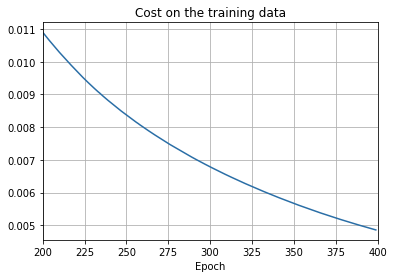

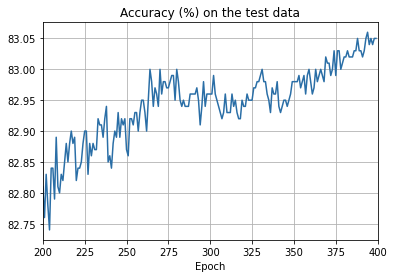

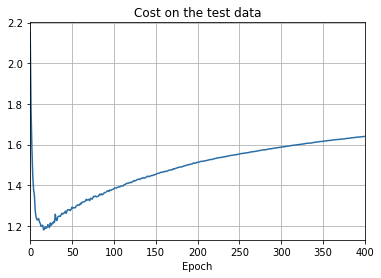

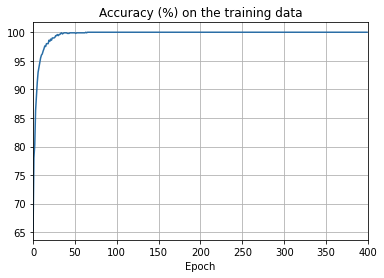

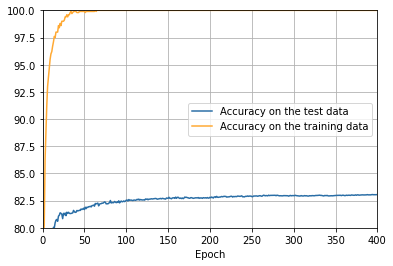

In [1]:
sys.path.append('./src/')
import overfitting
overfitting.make_plots('network2_epochs400', num_epochs = 400)

#### overfitting is much less of a problem with the full 50,000 images

In [2]:
sys.path.append('./src/')
import overfitting
overfitting.run_network('network2_train50000_epochs30', 
                        num_epochs = 30, training_set_size=50000)

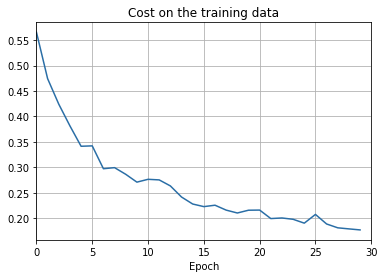

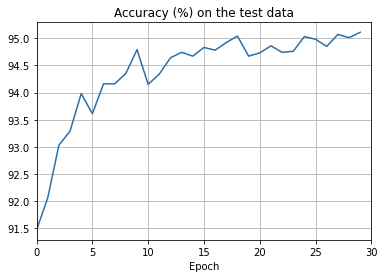

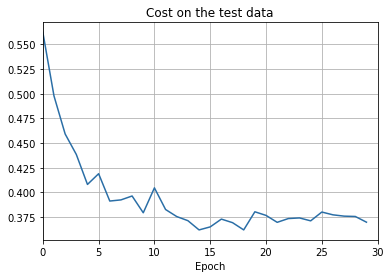

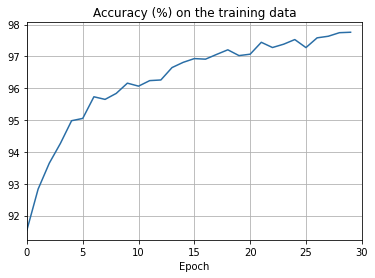

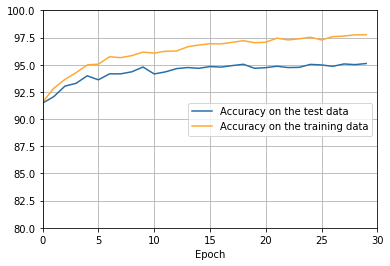

In [4]:
sys.path.append('./src/')
import overfitting
overfitting.make_plots('network2_train50000_epochs30', num_epochs = 30, 
                       training_set_size=50000, training_cost_xmin=0, 
                       test_accuracy_xmin=0)

#### Regularization

How to reduce overfitting?

- Increasing the amount of training data is one way of reducing overfitting.
- Reduce the size of our network.
- Regularization.

L2 regularized cross-entropy:
$$C=-\frac{1}{n}\sum_{xj}\left[y_j\ln a_j^L+(1-y_j)\ln(1-a_j^L)\right]+\frac{\lambda}{2n}\sum_w w^2\tag{3.31}$$

This is scaled by a factor $\lambda/2n$, where $\lambda>0$ is known as the regularization parameter, and $n$ is, as usual, the size of our training set.

L2 regularized quadratic cost:
$$C=\frac{1}{2n}\sum_{x}\left\lVert y-a^L\right\rVert^2+\frac{\lambda}{2n}\sum_w w^2\tag{3.32}$$

In both cases we can write the regularized cost function as
$$C=C_0+\frac{\lambda}{2n}\sum_w w^2\tag{3.33}$$
where $C_0$ is the original, unregularized cost function. 

Taking the partial derivatives of Equation (3.33) gives
$$\frac{\partial C}{\partial w}=\frac{\partial C_0}{\partial w}+\frac{\lambda}{n}w\tag{3.34}$$
$$\frac{\partial C}{\partial b}=\frac{\partial C_0}{\partial b}\tag{3.35}$$

and so the gradient descent learning rule for the biases doesn’t change from the usual rule:
$$b\to b-\eta\frac{\partial C_0}{\partial b}\tag{3.36}$$
$$w\to w-\eta\frac{\partial C_0}{\partial w}-\frac{\eta\lambda}{n}w=(1-\frac{\eta\lambda}{n})w-\eta\frac{\partial C_0}{\partial w}\tag{3.37}$$

This rescaling factor $(1-\frac{\eta\lambda}{n})$ is sometimes referred to as **weight decay**, since it makes the weights smaller. 

What about stochastic gradient descent? just as in unregularized stochastic gradient descent, we can estimate $\partial C_0/\partial w$ by averaging
over a mini-batch of $m$ training examples. Thus the regularized learning rule for stochastic gradient descent becomes
$$w\to (1-\frac{\eta\lambda}{n})w-\frac{\eta}{m}\sum_x\frac{\partial C_x}{\partial w}\tag{3.38}$$

$$b\to b-\frac{\eta}{m}\sum_x\frac{\partial C_x}{\partial b}\tag{3.39}$$
where the sum is over training examples $x$ in the mini-batch, and $C_x$ is the (unregularized) cost for each training example. This is exactly the same as the usual rule for stochastic gradient descent, except for the $1−\eta\lambda/n$ weight decay factor. 

#### Regularization with lambda=0.1, 1000 training data, 400 epochs

In [1]:
import overfitting
overfitting.run_network('network2_train1000_epochs400lambda0.1', 
                        num_epochs = 400,
                        lmbda = 0.1,
                        training_set_size=1000)

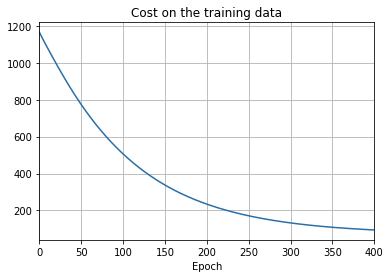

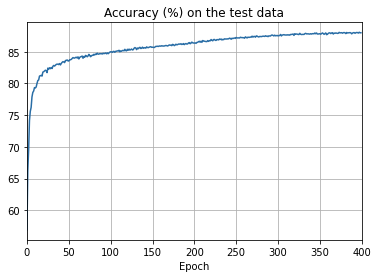

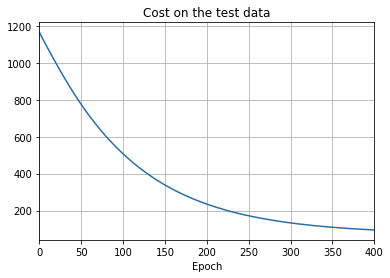

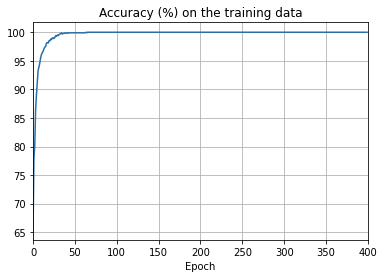

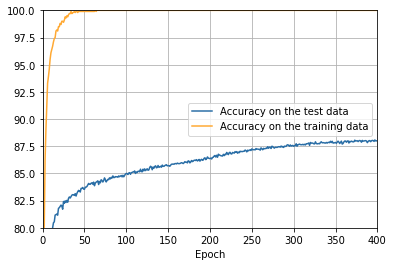

In [2]:
import overfitting
overfitting.make_plots('network2_train1000_epochs400lambda0.1', 
                       num_epochs = 400, 
                       training_set_size=1000, training_cost_xmin=0, 
                       test_accuracy_xmin=0)

- The cost on the training data decreases over the whole time, much as it did in the earlier, unregularized case.   
- This time the accuracy on the test_data continues to increase for the entire 400 epochs. Clearly, the use of regularization has suppressed overfitting.

#### Regularization with lambda=0.1, 50,000 training data, 30 epochs

In [3]:
import overfitting
overfitting.run_network('network2_train50000_epochs30lambda5', 
                        num_epochs = 30,
                        lmbda = 5.0,
                        training_set_size=50000)

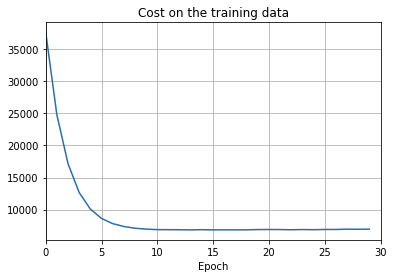

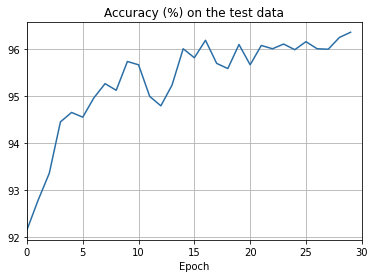

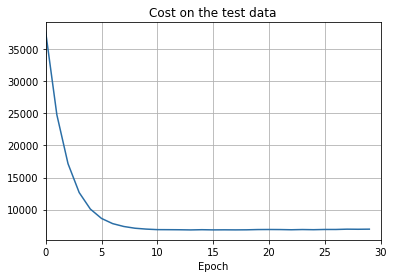

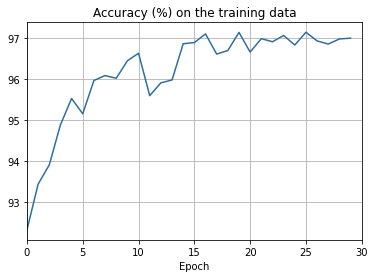

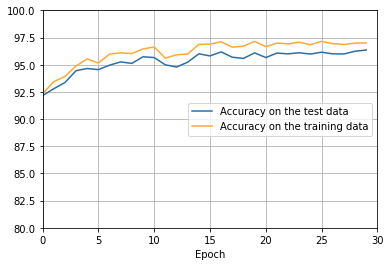

In [4]:
import overfitting
overfitting.make_plots('network2_train50000_epochs30lambda5', 
                       num_epochs = 30, 
                       training_set_size=50000, 
                       training_cost_xmin=0, 
                       test_accuracy_xmin=0)

There’s lots of good news here. 
- First, our classification accuracy on the test data is up, from 95 percent when running unregularized, to 96.49 percent. That’s a big improvement. 
- Second, we can see that the gap between results on the training and test data is much narrower than before, running at under a percent. That’s still a significant gap, but we’ve obviously made substantial progress reducing overfitting.

#### 100 hidden neurons, evaluation_data=validation_data

In [5]:
import overfitting_size784_100_10
overfitting.run_network('network2_train50000_epochs30lambda5_100_hidden_neurons', 
                        num_epochs = 30,
                        lmbda = 5.0,
                        training_set_size=50000)

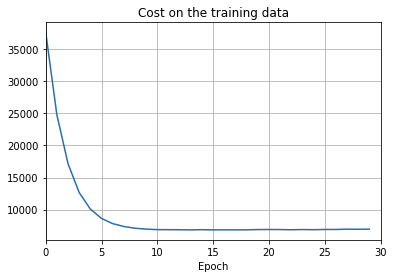

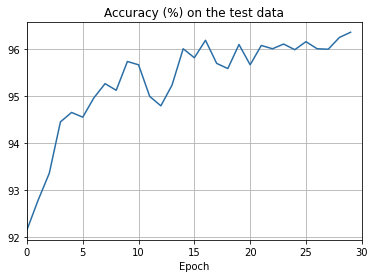

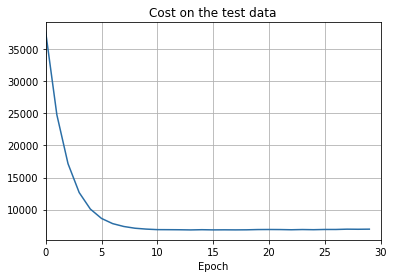

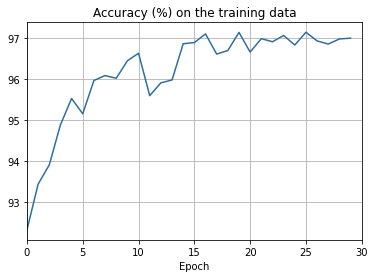

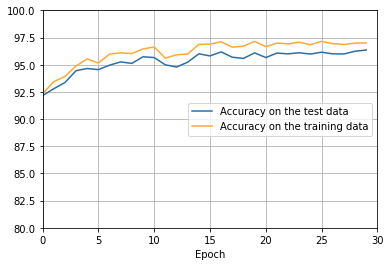

In [6]:
import overfitting_size784_100_10
overfitting.make_plots('network2_train50000_epochs30lambda5_100_hidden_neurons', 
                       num_epochs = 30, 
                       training_set_size=50000, 
                       training_cost_xmin=0, 
                       test_accuracy_xmin=0)

The final result is a classification accuracy of 96.5 percent on the validation data. That’s a
big jump from the 30 hidden neuron case.

#### Artificially expanding the training data

In [ ]:
"""more_data
~~~~~~~~~~~~

Plot graphs to illustrate the performance of MNIST when different size
training sets are used.

"""

# Standard library
import json
import random
import sys

# My library
import mnist_loader
import network2_quiet

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

# The sizes to use for the different training sets
SIZES = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000] 

def main():
    run_networks()
    run_svms()
    make_plots()
                       
def run_networks():
    # Make results more easily reproducible
    random.seed(12345678)
    np.random.seed(12345678)
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
    training_data = list(training_data)
    validation_data = list(validation_data)
    net = network2_quiet.Network([784, 30, 10], cost=network2_quiet.CrossEntropyCost())
    accuracies = []
    for size in SIZES:
        print("\nTraining network with data set size %s" % size)
        net.large_weight_initializer()
        num_epochs = int(1500000 / size)
        net.SGD(training_data[:size], num_epochs, 10, 0.5, lmbda = size*0.0001)
        accuracy = net.accuracy(validation_data)/100.0
        print("Accuracy was %s percent" % accuracy)
        accuracies.append(accuracy)
    f = open("more_data.json", "w")
    json.dump(accuracies, f)
    f.close()

def run_svms():
    svm_training_data, svm_validation_data, svm_test_data \
        = mnist_loader.load_data()
    accuracies = []
    for size in SIZES:
        print("\nTraining SVM with data set size %s" % size)
        clf = svm.SVC()
        clf.fit(svm_training_data[0][:size], svm_training_data[1][:size])
        predictions = [int(a) for a in clf.predict(svm_validation_data[0])]
        accuracy = sum(int(a == y) for a, y in 
                       zip(predictions, svm_validation_data[1])) / 100.0
        print("Accuracy was %s percent" % accuracy)
        accuracies.append(accuracy)
    f = open("more_data_svm.json", "w")
    json.dump(accuracies, f)
    f.close()

def make_plots():
    f = open("more_data.json", "r")
    accuracies = json.load(f)
    f.close()
    f = open("more_data_svm.json", "r")
    svm_accuracies = json.load(f)
    f.close()
    make_linear_plot(accuracies)
    make_log_plot(accuracies)
    make_combined_plot(accuracies, svm_accuracies)

def make_linear_plot(accuracies):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(SIZES, accuracies, color='#2A6EA6')
    ax.plot(SIZES, accuracies, "o", color='#FFA933')
    ax.set_xlim(0, 50000)
    ax.set_ylim(60, 100)
    ax.grid(True)
    ax.set_xlabel('Training set size')
    ax.set_title('Accuracy (%) on the validation data')
    plt.show()

def make_log_plot(accuracies):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(SIZES, accuracies, color='#2A6EA6')
    ax.plot(SIZES, accuracies, "o", color='#FFA933')
    ax.set_xlim(100, 50000)
    ax.set_ylim(60, 100)
    ax.set_xscale('log')
    ax.grid(True)
    ax.set_xlabel('Training set size')
    ax.set_title('Accuracy (%) on the validation data')
    plt.show()

def make_combined_plot(accuracies, svm_accuracies):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(SIZES, accuracies, color='#2A6EA6')
    ax.plot(SIZES, accuracies, "o", color='#2A6EA6', 
            label='Neural network accuracy (%)')
    ax.plot(SIZES, svm_accuracies, color='#FFA933')
    ax.plot(SIZES, svm_accuracies, "o", color='#FFA933',
            label='SVM accuracy (%)')
    ax.set_xlim(100, 50000)
    ax.set_ylim(25, 100)
    ax.set_xscale('log')
    ax.grid(True)
    ax.set_xlabel('Training set size')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    main()



Training network with data set size 100
Accuracy was 68.62 percent

Training network with data set size 200
Accuracy was 75.97 percent

Training network with data set size 500
Accuracy was 85.16 percent

Training network with data set size 1000
Accuracy was 89.05 percent

Training network with data set size 2000
Accuracy was 91.05 percent

Training network with data set size 5000
Accuracy was 93.25 percent

Training network with data set size 10000
Accuracy was 94.65 percent

Training network with data set size 20000
Accuracy was 95.52 percent

Training network with data set size 50000
Accuracy was 96.25 percent

Training SVM with data set size 100
Accuracy was 66.77 percent

Training SVM with data set size 200
Accuracy was 77.6 percent

Training SVM with data set size 500
Accuracy was 87.64 percent

Training SVM with data set size 1000
Accuracy was 91.38 percent

Training SVM with data set size 2000
Accuracy was 93.42 percent

Training SVM with data set size 5000
Accuracy was 95.65 p

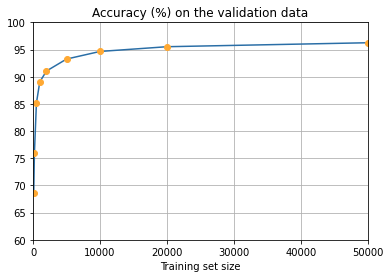

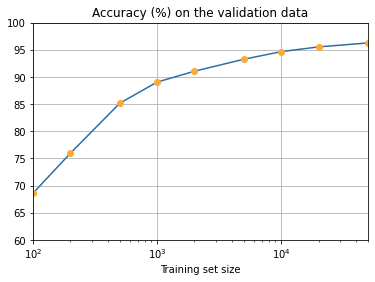

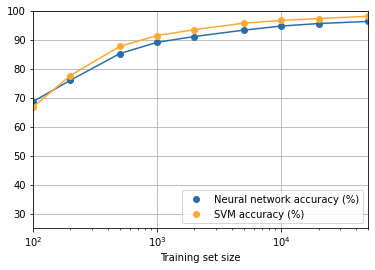

In [1]:
import sys
sys.path.append('./src/')
import more_data
more_data.main()

It seems clear that the graph is still going up toward the end. This suggests that if we used
vastly more training data – say, millions or even billions of handwriting samples, instead of
just 50,000 – then we’d likely get considerably better performance, even from this very small
network.

### 3.3 Weight initialization

In [ ]:
"""weight_initialization 
~~~~~~~~~~~~~~~~~~~~~~~~

This program shows how weight initialization affects training.  In
particular, we'll plot out how the classification accuracies improve
using either large starting weights, whose standard deviation is 1, or
the default starting weights, whose standard deviation is 1 over the
square root of the number of input neurons.

"""

# Standard library
import json
import random
import sys

# My library

import mnist_loader
import network2_quiet

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np

def main(filename, n, eta):
    run_network(filename, n, eta)
    make_plot(filename)
                       
def run_network(filename, n, eta):
    """Train the network using both the default and the large starting
    weights.  Store the results in the file with name ``filename``,
    where they can later be used by ``make_plots``.

    """
    # Make results more easily reproducible
    random.seed(12345678)
    np.random.seed(12345678)
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
    training_data = list(training_data)

    net = network2_quiet.Network([784, n, 10], cost=network2_quiet.CrossEntropyCost)
    print("Train the network using the default starting weights.")
    net.default_weight_initializer()
    default_vc, default_va, default_tc, default_ta \
        = net.SGD(training_data, 30, 10, eta, lmbda=5.0,
                  evaluation_data=validation_data, 
                  monitor_evaluation_accuracy=True,
                  monitor_evaluation_cost=True,  
                  monitor_training_cost=True, 
                  monitor_training_accuracy=True)
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
    training_data = list(training_data)
    print("Train the network using the large starting weights.")
    net2 = network2_quiet.Network([784, n, 10], cost=network2_quiet.CrossEntropyCost)
    net2.large_weight_initializer()
    large_vc, large_va, large_tc, large_ta \
        = net2.SGD(training_data, 30, 10, eta, lmbda=5.0,
                  evaluation_data=validation_data, 
                  monitor_evaluation_accuracy=True,
                  monitor_evaluation_cost=True,  
                  monitor_training_cost=True, 
                  monitor_training_accuracy=True)
    f = open(filename, "w")
    json.dump({"default_weight_initialization":
               [default_vc, default_va, default_tc, default_ta],
               "large_weight_initialization":
               [large_vc, large_va, large_tc, large_ta]}, 
              f)
    f.close()

def make_plot(filename):
    """Load the results from the file ``filename``, and generate the
    corresponding plot.

    """
    f = open(filename, "r")
    results = json.load(f)
    f.close()
    default_vc, default_va, default_tc, default_ta = results[
        "default_weight_initialization"]
    large_vc, large_va, large_tc, large_ta = results[
        "large_weight_initialization"]
    # Convert raw classification numbers to percentages, for plotting
    default_va = [x/100.0 for x in default_va]
    large_va = [x/100.0 for x in large_va]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(0, 30, 1), large_va, color='#2A6EA6',
            label="Old approach to weight initialization")
    ax.plot(np.arange(0, 30, 1), default_va, color='#FFA933', 
            label="New approach to weight initialization")
    ax.set_xlim([0, 30])
    ax.set_xlabel('Epoch')
    ax.set_ylim([80, 100])
    ax.set_title('Classification accuracy')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    main()


Train the network using the default starting weights.
Train the network using the large starting weights.


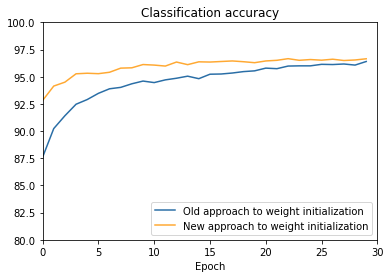

In [1]:
import sys
sys.path.append('./src/')
import weight_initialization
weight_initialization.main(filename='weight_initialization_30', 
                           n=30, eta=0.1)

Train the network using the default starting weights.
Train the network using the large starting weights.


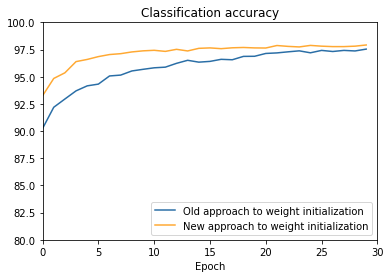

In [2]:
import weight_initialization
weight_initialization.main(filename='weight_initialization_100', 
                           n=100, eta=0.1)

### 3.5 How to choose a neural network’s hyper-parameters?

In [ ]:
"""multiple_eta
~~~~~~~~~~~~~~~

This program shows how different values for the learning rate affect
training.  In particular, we'll plot out how the cost changes using
three different values for eta.

"""

# Standard library
import json
import random
import sys

# My library
import mnist_loader
import network2_quiet

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np

# Constants
LEARNING_RATES = [0.025, 0.25, 2.5]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033']
NUM_EPOCHS = 30

def main():
    run_networks()
    make_plot()

def run_networks():
    """Train networks using three different values for the learning rate,
    and store the cost curves in the file ``multiple_eta.json``, where
    they can later be used by ``make_plot``.

    """
    # Make results more easily reproducible
    random.seed(12345678)
    np.random.seed(12345678)
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
    training_data = list(training_data)
    results = []
    for eta in LEARNING_RATES:
        print("\nTrain a network using eta = "+str(eta))
        net = network2_quiet.Network([784, 30, 10])
        results.append(
            net.SGD(training_data, NUM_EPOCHS, 10, eta, lmbda=5.0,
                    evaluation_data=validation_data, 
                    monitor_training_cost=True))
    f = open("multiple_eta.json", "w")
    json.dump(results, f)
    f.close()

def make_plot():
    f = open("multiple_eta.json", "r")
    results = json.load(f)
    f.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for eta, result, color in zip(LEARNING_RATES, results, COLORS):
        _, _, training_cost, _ = result
        ax.plot(np.arange(NUM_EPOCHS), training_cost, "o-",
                label="$\eta$ = "+str(eta),
                color=color)
    ax.set_xlim([0, NUM_EPOCHS])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cost')
    plt.legend(loc='upper right')
    plt.show()

if __name__ == "__main__":
    main()


Train a network using eta = 0.025

Train a network using eta = 0.25

Train a network using eta = 2.5


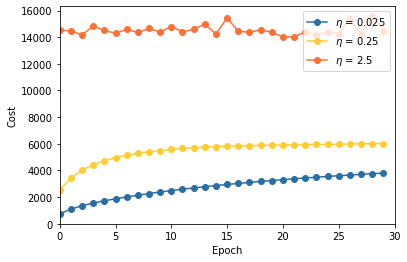

In [1]:
import sys
sys.path.append('./src/')
import multiple_eta
multiple_eta.main()

## 4. A visual proof that neural nets can compute any function

## 5. Why are deep neural networks hard to train?

In [3]:
import mnist_loader
import network2

training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
training_data = list(training_data)
net = network2.Network([784, 30, 30, 10])
net.SGD(training_data , 30, 10, 0.1, lmbda=5.0, evaluation_data=validation_data, 
        monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9229 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9452 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9515 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9587 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9596 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9631 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9638 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9646 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9662 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9651 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9646 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9665 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9680 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 9655 / 10000
Epoch 14 training complete
Accuracy on evalu

([],
 [9229,
  9452,
  9515,
  9587,
  9596,
  9631,
  9638,
  9646,
  9662,
  9651,
  9646,
  9665,
  9680,
  9655,
  9659,
  9679,
  9689,
  9677,
  9671,
  9675,
  9664,
  9680,
  9658,
  9679,
  9671,
  9681,
  9666,
  9698,
  9697,
  9671],
 [],
 [])

In [ ]:
"""generate_gradient.py
~~~~~~~~~~~~~~~~~~~~~~~

Use network2 to figure out the average starting values of the gradient
error terms \delta^l_j = \partial C / \partial z^l_j = \partial C /
\partial b^l_j.

"""

#### Libraries
# Standard library
import json
import math
import random
import shutil
import functools
import sys

# My library
import mnist_loader
import network2_quiet

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np

def main():
    # Load the data
    full_td, _, _ = mnist_loader.load_data_wrapper()
    full_td=list(full_td)
    td = full_td[:1000] # Just use the first 1000 items of training data
    epochs = 500 # Number of epochs to train for

    print("\nTwo hidden layers:")
    net = network2_quiet.Network([784, 30, 30, 10])
    initial_norms(td, net)
    abbreviated_gradient = [
        ag[:6] for ag in get_average_gradient(net, td)[:-1]] 
    print("Saving the averaged gradient for the top six neurons in each "+\
        "layer.\nWARNING: This will affect the look of the book, so be "+\
        "sure to check the\nrelevant material (early chapter 5).")
    f = open("initial_gradient.json", "w")
    json.dump(abbreviated_gradient, f)
    f.close()
    #shutil.copy("initial_gradient.json", "../../js/initial_gradient.json")
    training(td, net, epochs, "norms_during_training_2_layers.json")
    plot_training(
        epochs, "norms_during_training_2_layers.json", 2)

    print("\nThree hidden layers:")
    net = network2_quiet.Network([784, 30, 30, 30, 10])
    initial_norms(td, net)
    training(td, net, epochs, "norms_during_training_3_layers.json")
    plot_training(
        epochs, "norms_during_training_3_layers.json", 3)

    print("\nFour hidden layers:")
    net = network2_quiet.Network([784, 30, 30, 30, 30, 10])
    initial_norms(td, net)
    training(td, net, epochs, 
             "norms_during_training_4_layers.json")
    plot_training(
        epochs, "norms_during_training_4_layers.json", 4)

def initial_norms(training_data, net):
    average_gradient = get_average_gradient(net, training_data)
    norms = [list_norm(avg) for avg in average_gradient[:-1]]
    print("Average gradient for the hidden layers: "+str(norms))
    
def training(training_data, net, epochs, filename):
    norms = []
    for j in range(epochs):
        average_gradient = get_average_gradient(net, training_data)
        norms.append([list_norm(avg) for avg in average_gradient[:-1]])
        #print("Epoch: %s" % j)
        net.SGD(training_data, 1, 1000, 0.1, lmbda=5.0)
    f = open(filename, "w")
    json.dump(norms, f)
    f.close()

def plot_training(epochs, filename, num_layers):
    f = open(filename, "r")
    norms = json.load(f)
    f.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = ["#2A6EA6", "#FFA933", "#FF5555", "#55FF55", "#5555FF"]
    for j in range(num_layers):
        ax.plot(np.arange(epochs), 
                [n[j] for n in norms], 
                color=colors[j],
                label="Hidden layer %s" % (j+1,))
    ax.set_xlim([0, epochs])
    ax.grid(True)
    ax.set_xlabel('Number of epochs of training')
    ax.set_title('Speed of learning: %s hidden layers' % num_layers)
    ax.set_yscale('log')
    plt.legend(loc="upper right")
    fig_filename = "training_speed_%s_layers.png" % num_layers
    plt.savefig(fig_filename)
    #shutil.copy(fig_filename, "../../images/"+fig_filename)
    plt.show()

def get_average_gradient(net, training_data):
    nabla_b_results = [net.backprop(x, y)[0] for x, y in training_data]
    gradient = list_sum(nabla_b_results)
    return [(np.reshape(g, len(g))/len(training_data)).tolist() 
            for g in gradient]

def zip_sum(a, b): 
    return [x+y for (x, y) in zip(a, b)]

def list_sum(l):
    return functools.reduce(zip_sum, l)

def list_norm(l):
    return math.sqrt(sum([x*x for x in l]))

if __name__ == "__main__":
    main()



Two hidden layers:
Average gradient for the hidden layers: [0.07995550303221019, 0.35797820418358034]
Saving the averaged gradient for the top six neurons in each layer.
relevant material (early chapter 5).


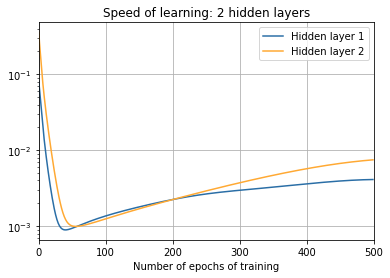


Three hidden layers:
Average gradient for the hidden layers: [0.004753898777059166, 0.023478628329819392, 0.1462598055887548]


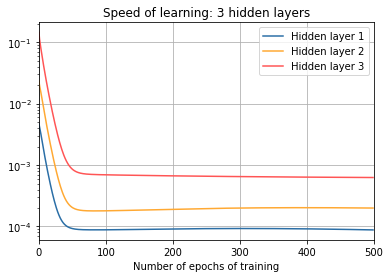


Four hidden layers:
Average gradient for the hidden layers: [0.002442800087315909, 0.014695951138216557, 0.07064677577913264, 0.2817046057228145]


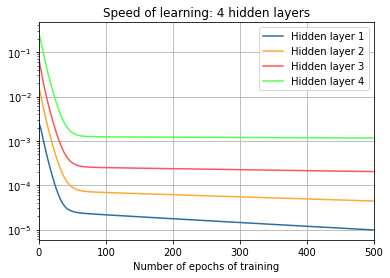

In [1]:
import sys
sys.path.append('./src/')
import generate_gradient
generate_gradient.main()

## 6. Deep learning

### 6.1 Introducing convolutional networks

In [ ]:
"""network3.py
~~~~~~~~~~~~~~

A Theano-based program for training and running simple neural
networks.

Supports several layer types (fully connected, convolutional, max
pooling, softmax), and activation functions (sigmoid, tanh, and
rectified linear units, with more easily added).

When run on a CPU, this program is much faster than network.py and
network2.py.  However, unlike network.py and network2.py it can also
be run on a GPU, which makes it faster still.

Because the code is based on Theano, the code is different in many
ways from network.py and network2.py.  However, where possible I have
tried to maintain consistency with the earlier programs.  In
particular, the API is similar to network2.py.  Note that I have
focused on making the code simple, easily readable, and easily
modifiable.  It is not optimized, and omits many desirable features.

This program incorporates ideas from the Theano documentation on
convolutional neural nets (notably,
http://deeplearning.net/tutorial/lenet.html ), from Misha Denil's
implementation of dropout (https://github.com/mdenil/dropout ), and
from Chris Olah (http://colah.github.io ).

"""

#### Libraries
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.nnet import conv
from theano.tensor.nnet import conv2d
from theano.tensor.nnet import softmax
from theano.tensor import shared_randomstreams
from theano.tensor.signal.pool import pool_2d

# Activation functions for neurons
def linear(z): return z
def ReLU(z): return T.maximum(0.0, z)
from theano.tensor.nnet import sigmoid
from theano.tensor import tanh


#### Constants
GPU = False
if GPU:
    print("Trying to run under a GPU.  If this is not desired, then modify "+\
        "network3.py\nto set the GPU flag to False.")
    try: theano.config.device = 'gpu'
    except: pass # it's already set
    theano.config.floatX = 'float32'
else:
    print("Running with a CPU.  If this is not desired, then the modify "+\
        "network3.py to set\nthe GPU flag to True.")

#### Load the MNIST data
def load_data_shared(filename="mnist.pkl.gz"):
    f = gzip.open(filename, 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    def shared(data):
        """Place the data into shared variables.  This allows Theano to copy
        the data to the GPU, if one is available.

        """
        shared_x = theano.shared(
            np.asarray(data[0], dtype=theano.config.floatX), borrow=True)
        shared_y = theano.shared(
            np.asarray(data[1], dtype=theano.config.floatX), borrow=True)
        return shared_x, T.cast(shared_y, "int32")
    return [shared(training_data), shared(validation_data), shared(test_data)]

#### Main class used to construct and train networks
class Network(object):

    def __init__(self, layers, mini_batch_size):
        """Takes a list of `layers`, describing the network architecture, and
        a value for the `mini_batch_size` to be used during training
        by stochastic gradient descent.

        """
        self.layers = layers
        self.mini_batch_size = mini_batch_size
        self.params = [param for layer in self.layers for param in layer.params]
        self.x = T.matrix("x")
        self.y = T.ivector("y")
        init_layer = self.layers[0]
        init_layer.set_inpt(self.x, self.x, self.mini_batch_size)
        for j in range(1, len(self.layers)): # xrange() was renamed to range() in Python 3.
            prev_layer, layer  = self.layers[j-1], self.layers[j]
            layer.set_inpt(
                prev_layer.output, prev_layer.output_dropout, self.mini_batch_size)
        self.output = self.layers[-1].output
        self.output_dropout = self.layers[-1].output_dropout

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            validation_data, test_data, lmbda=0.0):
        """Train the network using mini-batch stochastic gradient descent."""
        training_x, training_y = training_data
        validation_x, validation_y = validation_data
        test_x, test_y = test_data

        # compute number of minibatches for training, validation and testing
        num_training_batches = int(size(training_data)/mini_batch_size)
        num_validation_batches = int(size(validation_data)/mini_batch_size)
        num_test_batches = int(size(test_data)/mini_batch_size)

        # define the (regularized) cost function, symbolic gradients, and updates
        l2_norm_squared = sum([(layer.w**2).sum() for layer in self.layers])
        cost = self.layers[-1].cost(self)+\
               0.5*lmbda*l2_norm_squared/num_training_batches
        grads = T.grad(cost, self.params)
        updates = [(param, param-eta*grad)
                   for param, grad in zip(self.params, grads)]

        # define functions to train a mini-batch, and to compute the
        # accuracy in validation and test mini-batches.
        i = T.lscalar() # mini-batch index
        train_mb = theano.function(
            [i], cost, updates=updates,
            givens={
                self.x:
                training_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                training_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        validate_mb_accuracy = theano.function(
            [i], self.layers[-1].accuracy(self.y),
            givens={
                self.x:
                validation_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                validation_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        test_mb_accuracy = theano.function(
            [i], self.layers[-1].accuracy(self.y),
            givens={
                self.x:
                test_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                test_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        self.test_mb_predictions = theano.function(
            [i], self.layers[-1].y_out,
            givens={
                self.x:
                test_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        # Do the actual training
        best_validation_accuracy = 0.0
        for epoch in range(epochs):
            for minibatch_index in range(num_training_batches):
                iteration = num_training_batches*epoch+minibatch_index
                if iteration % 100000 == 0:
                    print("Training mini-batch number {0}".format(iteration))
                cost_ij = train_mb(minibatch_index)
                if (iteration+1) % num_training_batches == 0:
                    validation_accuracy = np.mean(
                        [validate_mb_accuracy(j) for j in range(num_validation_batches)])
                    print("Epoch {0}: validation accuracy {1:.2%}".format(
                        epoch, validation_accuracy))
                    if validation_accuracy >= best_validation_accuracy:
                        print("This is the best validation accuracy to date.")
                        best_validation_accuracy = validation_accuracy
                        best_iteration = iteration
                        if test_data:
                            test_accuracy = np.mean(
                                [test_mb_accuracy(j) for j in range(num_test_batches)])
                            print('The corresponding test accuracy is {0:.2%}'.format(
                                test_accuracy))
        print("Finished training network.")
        print("Best validation accuracy of {0:.2%} obtained at iteration {1}".format(
            best_validation_accuracy, best_iteration))
        print("Corresponding test accuracy of {0:.2%}".format(test_accuracy))

#### Define layer types

class ConvPoolLayer(object):
    """Used to create a combination of a convolutional and a max-pooling
    layer.  A more sophisticated implementation would separate the
    two, but for our purposes we'll always use them together, and it
    simplifies the code, so it makes sense to combine them.

    """

    def __init__(self, filter_shape, image_shape, poolsize=(2, 2),
                 activation_fn=sigmoid):
        """`filter_shape` is a tuple of length 4, whose entries are the number
        of filters, the number of input feature maps, the filter height, and the
        filter width.

        `image_shape` is a tuple of length 4, whose entries are the
        mini-batch size, the number of input feature maps, the image
        height, and the image width.

        `poolsize` is a tuple of length 2, whose entries are the y and
        x pooling sizes.

        """
        self.filter_shape = filter_shape
        self.image_shape = image_shape
        self.poolsize = poolsize
        self.activation_fn=activation_fn
        # initialize weights and biases
        n_out = (filter_shape[0]*np.prod(filter_shape[2:])/np.prod(poolsize))
        self.w = theano.shared(
            np.asarray(
                np.random.normal(loc=0, scale=np.sqrt(1.0/n_out), size=filter_shape),
                dtype=theano.config.floatX),
            borrow=True)
        self.b = theano.shared(
            np.asarray(
                np.random.normal(loc=0, scale=1.0, size=(filter_shape[0],)),
                dtype=theano.config.floatX),
            borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape(self.image_shape)
        conv_out = conv2d(
            input=self.inpt, filters=self.w, filter_shape=self.filter_shape,
            input_shape=self.image_shape)
        pooled_out = pool_2d(
            input=conv_out, ws=self.poolsize, ignore_border=True)
        self.output = self.activation_fn(
            pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))
        self.output_dropout = self.output # no dropout in the convolutional layers

class FullyConnectedLayer(object):

    def __init__(self, n_in, n_out, activation_fn=sigmoid, p_dropout=0.0):
        self.n_in = n_in
        self.n_out = n_out
        self.activation_fn = activation_fn
        self.p_dropout = p_dropout
        # Initialize weights and biases
        self.w = theano.shared(
            np.asarray(
                np.random.normal(
                    loc=0.0, scale=np.sqrt(1.0/n_out), size=(n_in, n_out)),
                dtype=theano.config.floatX),
            name='w', borrow=True)
        self.b = theano.shared(
            np.asarray(np.random.normal(loc=0.0, scale=1.0, size=(n_out,)),
                       dtype=theano.config.floatX),
            name='b', borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape((mini_batch_size, self.n_in))
        self.output = self.activation_fn(
            (1-self.p_dropout)*T.dot(self.inpt, self.w) + self.b)
        self.y_out = T.argmax(self.output, axis=1)
        self.inpt_dropout = dropout_layer(
            inpt_dropout.reshape((mini_batch_size, self.n_in)), self.p_dropout)
        self.output_dropout = self.activation_fn(
            T.dot(self.inpt_dropout, self.w) + self.b)

    def accuracy(self, y):
        "Return the accuracy for the mini-batch."
        return T.mean(T.eq(y, self.y_out))

class SoftmaxLayer(object):

    def __init__(self, n_in, n_out, p_dropout=0.0):
        self.n_in = n_in
        self.n_out = n_out
        self.p_dropout = p_dropout
        # Initialize weights and biases
        self.w = theano.shared(
            np.zeros((n_in, n_out), dtype=theano.config.floatX),
            name='w', borrow=True)
        self.b = theano.shared(
            np.zeros((n_out,), dtype=theano.config.floatX),
            name='b', borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape((mini_batch_size, self.n_in))
        self.output = softmax((1-self.p_dropout)*T.dot(self.inpt, self.w) + self.b)
        self.y_out = T.argmax(self.output, axis=1)
        self.inpt_dropout = dropout_layer(
            inpt_dropout.reshape((mini_batch_size, self.n_in)), self.p_dropout)
        self.output_dropout = softmax(T.dot(self.inpt_dropout, self.w) + self.b)

    def cost(self, net):
        "Return the log-likelihood cost."
        return -T.mean(T.log(self.output_dropout)[T.arange(net.y.shape[0]), net.y])

    def accuracy(self, y):
        "Return the accuracy for the mini-batch."
        return T.mean(T.eq(y, self.y_out))


#### Miscellanea
def size(data):
    "Return the size of the dataset `data`."
    return data[0].get_value(borrow=True).shape[0]

def dropout_layer(layer, p_dropout):
    srng = shared_randomstreams.RandomStreams(
        np.random.RandomState(0).randint(999999))
    mask = srng.binomial(n=1, p=1-p_dropout, size=layer.shape)
    return layer*T.cast(mask, theano.config.floatX)


In [1]:
import sys
sys.path.append('./src/')
import network3
from network3 import Network
from network3 import ConvPoolLayer , FullyConnectedLayer , SoftmaxLayer

Running with a CPU.  If this is not desired, then the modify network3.py to set
the GPU flag to True.


In [2]:
training_data , validation_data , test_data = network3.load_data_shared()
mini_batch_size = 10

In [3]:
net = Network([FullyConnectedLayer(n_in=784, n_out=100),SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)

In [4]:
net.SGD(training_data, 60, mini_batch_size, 0.1, validation_data, test_data)

Training mini-batch number 0
Epoch 0: validation accuracy 92.53%
The corresponding test accuracy is 91.76%
Epoch 1: validation accuracy 94.68%
The corresponding test accuracy is 94.07%
Epoch 2: validation accuracy 95.85%
The corresponding test accuracy is 95.19%
Epoch 3: validation accuracy 96.47%
The corresponding test accuracy is 95.76%
Epoch 4: validation accuracy 96.78%
The corresponding test accuracy is 96.30%
Epoch 5: validation accuracy 97.04%
The corresponding test accuracy is 96.66%
Epoch 6: validation accuracy 97.22%
The corresponding test accuracy is 96.93%
Epoch 7: validation accuracy 97.26%
The corresponding test accuracy is 97.14%
Epoch 8: validation accuracy 97.38%
The corresponding test accuracy is 97.25%
Epoch 9: validation accuracy 97.37%
Epoch 10: validation accuracy 97.38%
The corresponding test accuracy is 97.38%
Epoch 11: validation accuracy 97.39%
The corresponding test accuracy is 97.40%
Epoch 12: validation accuracy 97.49%
The corresponding test accuracy is 97.

I obtained a best classification accuracy of 97.79 percent.

Let’s begin by inserting a convolutional layer, right at the beginning of the network. We’ll
use 5 by 5 local receptive fields, a stride length of 1, and 20 feature maps. We’ll also insert
a max-pooling layer, which combines the features using 2 by 2 pooling windows. So the
overall network architecture looks much like the architecture discussed in the last section,
but with an extra fully-connected layer:

![convolutional_network](fig/convolutional_network.png)

In [5]:
net = Network([ConvPoolLayer(image_shape=(mini_batch_size , 1, 28, 28),
                             filter_shape=(20, 1, 5, 5),
                             poolsize=(2, 2)),
               FullyConnectedLayer(n_in=20*12*12, n_out=100),
               SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)

In [6]:
net.SGD(training_data, 60, mini_batch_size, 0.1, validation_data, test_data)

Training mini-batch number 0
Epoch 0: validation accuracy 94.32%
The corresponding test accuracy is 93.55%
Epoch 1: validation accuracy 96.35%
The corresponding test accuracy is 95.89%
Epoch 2: validation accuracy 97.25%
The corresponding test accuracy is 96.92%
Epoch 3: validation accuracy 97.75%
The corresponding test accuracy is 97.42%
Epoch 4: validation accuracy 97.96%
The corresponding test accuracy is 97.75%
Epoch 5: validation accuracy 98.15%
The corresponding test accuracy is 97.90%
Epoch 6: validation accuracy 98.28%
The corresponding test accuracy is 98.10%
Epoch 7: validation accuracy 98.34%
The corresponding test accuracy is 98.26%
Epoch 8: validation accuracy 98.39%
The corresponding test accuracy is 98.45%
Epoch 9: validation accuracy 98.44%
The corresponding test accuracy is 98.51%
Epoch 10: validation accuracy 98.51%
The corresponding test accuracy is 98.52%
Epoch 11: validation accuracy 98.54%
The corresponding test accuracy is 98.55%
Epoch 12: validation accuracy 98.

That gets us to 98.80 percent accuracy, which is a considerable improvement over any of
our previous results.

Let’s try inserting a second convolutional-pooling layer. We’ll make the insertion between
the existing convolutional-pooling layer and the fully-connected hidden layer. Again, we’ll
use a $5\times 5$ local receptive field, and pool over $2 \times 2$ regions. Let’s see what happens when
we train using similar hyper-parameters to before:

In [7]:
net = Network([ConvPoolLayer(image_shape=(mini_batch_size , 1, 28, 28),
                             filter_shape=(20, 1, 5, 5),
                             poolsize=(2, 2)),
               ConvPoolLayer(image_shape=(mini_batch_size , 20, 12, 12),
                             filter_shape=(40, 20, 5, 5),
                             poolsize=(2, 2)),
               FullyConnectedLayer(n_in=40*4*4, n_out=100),
               SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)

In [8]:
net.SGD(training_data, 60, mini_batch_size, 0.1, validation_data, test_data)

Training mini-batch number 0
Epoch 0: validation accuracy 92.86%
The corresponding test accuracy is 92.59%
Epoch 1: validation accuracy 96.78%
The corresponding test accuracy is 96.52%
Epoch 2: validation accuracy 97.70%
The corresponding test accuracy is 97.48%
Epoch 3: validation accuracy 98.04%
The corresponding test accuracy is 97.85%
Epoch 4: validation accuracy 98.22%
The corresponding test accuracy is 98.15%
Epoch 5: validation accuracy 98.40%
The corresponding test accuracy is 98.33%
Epoch 6: validation accuracy 98.52%
The corresponding test accuracy is 98.46%
Epoch 7: validation accuracy 98.59%
The corresponding test accuracy is 98.52%
Epoch 8: validation accuracy 98.62%
The corresponding test accuracy is 98.54%
Epoch 9: validation accuracy 98.65%
The corresponding test accuracy is 98.62%
Epoch 10: validation accuracy 98.70%
The corresponding test accuracy is 98.67%
Epoch 11: validation accuracy 98.71%
The corresponding test accuracy is 98.69%
Epoch 12: validation accuracy 98.

Once again, we get an improvement: we’re now at 99.06 percent classification accuracy!

#### Using rectified linear units 

As a beginning, let’s change our neurons so that instead of using a sigmoid activation function, we use rectified linear units. That is, we’ll use the activation function $f(z) \equiv max(0, z)$. We’ll train for $60$ epochs, with a learning rate of $\eta = 0.03$. I also found that it helps a little to use some $l2$ regularization, with regularization parameter $\lambda = 0.1$:

In [9]:
from network3 import ReLU
net = Network([ConvPoolLayer(image_shape=(mini_batch_size , 1, 28, 28),
                             filter_shape=(20, 1, 5, 5), poolsize=(2, 2), activation_fn=ReLU),
               ConvPoolLayer(image_shape=(mini_batch_size , 20, 12, 12), filter_shape=(40, 20, 5, 5),
                             poolsize=(2, 2), activation_fn=ReLU),
               FullyConnectedLayer(n_in=40*4*4, n_out=100, activation_fn=ReLU),
               SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)

In [10]:
net.SGD(training_data , 60, mini_batch_size , 0.03, validation_data , test_data ,lmbda=0.1)

Training mini-batch number 0
Epoch 0: validation accuracy 97.37%
The corresponding test accuracy is 96.92%
Epoch 1: validation accuracy 98.00%
The corresponding test accuracy is 98.14%
Epoch 2: validation accuracy 98.23%
The corresponding test accuracy is 98.40%
Epoch 3: validation accuracy 98.39%
The corresponding test accuracy is 98.50%
Epoch 4: validation accuracy 98.38%
Epoch 5: validation accuracy 98.45%
The corresponding test accuracy is 98.58%
Epoch 6: validation accuracy 98.74%
The corresponding test accuracy is 98.68%
Epoch 7: validation accuracy 98.76%
The corresponding test accuracy is 98.72%
Epoch 8: validation accuracy 98.64%
Epoch 9: validation accuracy 98.22%
Epoch 10: validation accuracy 98.86%
The corresponding test accuracy is 98.79%
Epoch 11: validation accuracy 98.65%
Epoch 12: validation accuracy 99.05%
The corresponding test accuracy is 98.92%
Epoch 13: validation accuracy 98.78%
Epoch 14: validation accuracy 98.84%
Epoch 15: validation accuracy 98.77%
Epoch 16: v

I obtained a classification accuracy of 99.12 percent.

In [ ]:
"""expand_mnist.py
~~~~~~~~~~~~~~~~~~

Take the 50,000 MNIST training images, and create an expanded set of
250,000 images, by displacing each training image up, down, left and
right, by one pixel.  Save the resulting file to
../data/mnist_expanded.pkl.gz.

Note that this program is memory intensive, and may not run on small
systems.

"""

from __future__ import print_function

#### Libraries

# Standard library
import pickle
import gzip
import os.path
import random

# Third-party libraries
import numpy as np

print("Expanding the MNIST training set")

if os.path.exists("../data/mnist_expanded.pkl.gz"):
    print("The expanded training set already exists.  Exiting.")
else:
    f = gzip.open("../data/mnist.pkl.gz", 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    training_data, validation_data, test_data = u.load()
    f.close()
    expanded_training_pairs = []
    j = 0 # counter
    for x, y in zip(training_data[0], training_data[1]):
        expanded_training_pairs.append((x, y))
        image = np.reshape(x, (-1, 28))
        j += 1
        if j % 1000 == 0: print("Expanding image number", j)
        # iterate over data telling us the details of how to
        # do the displacement
        for d, axis, index_position, index in [
                (1,  0, "first", 0),
                (-1, 0, "first", 27),
                (1,  1, "last",  0),
                (-1, 1, "last",  27)]:
            new_img = np.roll(image, d, axis)
            if index_position == "first": 
                new_img[index, :] = np.zeros(28)
            else: 
                new_img[:, index] = np.zeros(28)
            expanded_training_pairs.append((np.reshape(new_img, 784), y))
    random.shuffle(expanded_training_pairs)
    expanded_training_data = [list(d) for d in zip(*expanded_training_pairs)]
    print("Saving expanded data. This may take a few minutes.")
    f = gzip.open("../data/mnist_expanded.pkl.gz", "w")
    pickle.dump((expanded_training_data, validation_data, test_data), f)
    f.close()


Running this program takes the 50,000 MNIST training images, and prepares an expanded
training set, with 250,000 training images. We can then use those training images to train
our network. We’ll use the same network as above, with rectified linear units.

In [11]:
expanded_training_data , _, _ = network3.load_data_shared("./data/mnist_expanded.pkl.gz")

In [12]:
net = Network([ConvPoolLayer(image_shape=(mini_batch_size , 1, 28, 28),
                             filter_shape=(20, 1, 5, 5),
                             poolsize=(2, 2),
                             activation_fn=ReLU),
               ConvPoolLayer(image_shape=(mini_batch_size , 20, 12, 12),
                             filter_shape=(40, 20, 5, 5),
                             poolsize=(2, 2),
                             activation_fn=ReLU),
               FullyConnectedLayer(n_in=40*4*4, n_out=100, activation_fn=ReLU),
               SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)

In [13]:
net.SGD(expanded_training_data, 60, mini_batch_size, 0.03, validation_data,test_data, lmbda=0.1)

Training mini-batch number 0
Epoch 0: validation accuracy 98.93%
The corresponding test accuracy is 99.18%
Epoch 1: validation accuracy 99.11%
The corresponding test accuracy is 99.32%
Epoch 2: validation accuracy 99.08%
Epoch 3: validation accuracy 99.08%
Training mini-batch number 100000
Epoch 4: validation accuracy 99.10%
Epoch 5: validation accuracy 99.13%
The corresponding test accuracy is 99.20%
Epoch 6: validation accuracy 98.97%
Epoch 7: validation accuracy 99.12%
Training mini-batch number 200000
Epoch 8: validation accuracy 99.21%
The corresponding test accuracy is 99.28%
Epoch 9: validation accuracy 99.11%
Epoch 10: validation accuracy 99.07%
Epoch 11: validation accuracy 99.24%
The corresponding test accuracy is 99.31%
Training mini-batch number 300000
Epoch 12: validation accuracy 99.19%
Epoch 13: validation accuracy 99.28%
The corresponding test accuracy is 99.31%
Epoch 14: validation accuracy 99.30%
The corresponding test accuracy is 99.23%
Epoch 15: validation accuracy 

Using 250,000 training images, we get 99.46% accurary.

#### Inserting an extra fully-connected layer:

In [14]:
net = Network([ConvPoolLayer(image_shape=(mini_batch_size , 1, 28, 28),
                             filter_shape=(20, 1, 5, 5),
                             poolsize=(2, 2),
                             activation_fn=ReLU),
               ConvPoolLayer(image_shape=(mini_batch_size , 20, 12, 12),
                             filter_shape=(40, 20, 5, 5),
                             poolsize=(2, 2),
                             activation_fn=ReLU),
               FullyConnectedLayer(n_in=40*4*4, n_out=100, activation_fn=ReLU),
               FullyConnectedLayer(n_in=100, n_out=100, activation_fn=ReLU),
               SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)

In [15]:
net.SGD(expanded_training_data , 60, mini_batch_size , 0.03, validation_data ,test_data , lmbda=0.1)

Training mini-batch number 0
Epoch 0: validation accuracy 98.63%
The corresponding test accuracy is 98.64%
Epoch 1: validation accuracy 99.06%
The corresponding test accuracy is 99.11%
Epoch 2: validation accuracy 99.07%
The corresponding test accuracy is 99.12%
Epoch 3: validation accuracy 98.90%
Training mini-batch number 100000
Epoch 4: validation accuracy 99.00%
Epoch 5: validation accuracy 98.91%
Epoch 6: validation accuracy 99.05%
Epoch 7: validation accuracy 98.88%
Training mini-batch number 200000
Epoch 8: validation accuracy 98.89%
Epoch 9: validation accuracy 98.88%
Epoch 10: validation accuracy 98.97%
Epoch 11: validation accuracy 99.01%
Training mini-batch number 300000
Epoch 12: validation accuracy 99.19%
The corresponding test accuracy is 99.20%
Epoch 13: validation accuracy 99.09%
Epoch 14: validation accuracy 99.25%
The corresponding test accuracy is 99.21%
Epoch 15: validation accuracy 99.00%
Training mini-batch number 400000
Epoch 16: validation accuracy 99.22%
Epoch 

#### dropout
Let’s try applying dropout to the final fully-connected layers:

In [16]:
net = Network([ConvPoolLayer(image_shape=(mini_batch_size , 1, 28, 28),
                             filter_shape=(20, 1, 5, 5),
                             poolsize=(2, 2),
                             activation_fn=ReLU),
               ConvPoolLayer(image_shape=(mini_batch_size , 20, 12, 12),
                             filter_shape=(40, 20, 5, 5),
                             poolsize=(2, 2),
                             activation_fn=ReLU),
               FullyConnectedLayer(n_in=40*4*4, n_out=1000, activation_fn=ReLU , p_dropout=0.5),
               FullyConnectedLayer(n_in=1000, n_out=1000, activation_fn=ReLU , p_dropout=0.5),
               SoftmaxLayer(n_in=1000, n_out=10, p_dropout=0.5)],mini_batch_size)

In [17]:
net.SGD(expanded_training_data, 40, mini_batch_size, 0.03, validation_data , test_data)

Training mini-batch number 0
Epoch 0: validation accuracy 98.52%
The corresponding test accuracy is 98.62%
Epoch 1: validation accuracy 99.05%
The corresponding test accuracy is 99.11%
Epoch 2: validation accuracy 99.24%
The corresponding test accuracy is 99.34%
Epoch 3: validation accuracy 99.27%
The corresponding test accuracy is 99.39%
Training mini-batch number 100000
Epoch 4: validation accuracy 99.35%
The corresponding test accuracy is 99.49%
Epoch 5: validation accuracy 99.32%
Epoch 6: validation accuracy 99.39%
The corresponding test accuracy is 99.50%
Epoch 7: validation accuracy 99.46%
The corresponding test accuracy is 99.56%
Training mini-batch number 200000
Epoch 8: validation accuracy 99.42%
Epoch 9: validation accuracy 99.44%
Epoch 10: validation accuracy 99.43%
Epoch 11: validation accuracy 99.49%
The corresponding test accuracy is 99.55%
Training mini-batch number 300000
Epoch 12: validation accuracy 99.43%
Epoch 13: validation accuracy 99.50%
The corresponding test ac

## Backpropagation

Backpropagation is a method for efficiently computing the gradient of the cost function of a neural network with respect to its parameters.  These partial derivatives can then be used to update the network's parameters using, e.g., gradient descent.  This may be the most common method for training neural networks.  Deriving backpropagation involves numerous clever applications of the chain rule for functions of vectors.  For a somewhat more accessible and readable (but slightly less complete) tutorial which uses notation similar to this one, please see
http://neuralnetworksanddeeplearning.com/chap2.html

## Review: The chain rule

The chain rule is a way to compute the derivative of a function whose variables are themselves functions of other variables.  If $C$ is a scalar-valued function of a scalar $z$ and $z$ is itself a scalar-valued function of another scalar variable $w$, then the chain rule states that
$$
\frac{\partial C}{\partial w} = \frac{\partial C}{\partial z}\frac{\partial z}{\partial w}
$$
For scalar-valued functions of more than one variable, the chain rule essentially becomes additive.  In other words, if $C$ is a scalar-valued function of $N$ variables $z_1, \ldots, z_N$, each of which is a function of some variable $w$, the chain rule states that
$$
\frac{\partial C}{\partial w} = \sum_{i = 1}^N \frac{\partial C}{\partial z_i}\frac{\partial z_i}{\partial w}
$$

## Notation

In the following derivation, we'll use the following notation:

$L$ - Number of layers in the network.

$N^n$ - Dimensionality of layer $n \in \{0, \ldots, L\}$.  $N^0$ is the dimensionality of the input; $N^L$ is the dimensionality of the output.

$W^m \in \mathbb{R}^{N^m \times N^{m - 1}}$ - Weight matrix for layer $m \in \{1, \ldots, L\}$.  $W^m_{ij}$ is the weight between the $i^{th}$ unit in layer $m$ and the $j^{th}$ unit in layer $m - 1$.

$b^m \in \mathbb{R}^{N^m}$ - Bias vector for layer $m$.

$\sigma^m$ - Nonlinear activation function of the units in layer $m$, applied elementwise.

$z^m \in \mathbb{R}^{N^m}$ - Linear mix of the inputs to layer $m$, computed by $z^m = W^m a^{m - 1} + b^m$.

$a^m \in \mathbb{R}^{N^m}$ - Activation of units in layer $m$, computed by $a^m = \sigma^m(z^m) = \sigma^m(W^m a^{m - 1} + b^m)$.  $a^L$ is the output of the network.  We define the special case $a^0$ as the input of the network.

$y \in \mathbb{R}^{N^L}$ - Target output of the network.

$C$ - Cost/error function of the network, which is a function of $a^L$ (the network output) and $y$ (treated as a constant).

## Backpropagation in general

In order to train the network using a gradient descent algorithm, we need to know the gradient of each of the parameters with respect to the cost/error function $C$; that is, we need to know $\frac{\partial C}{\partial W^m}$ and $\frac{\partial C}{\partial b^m}$.  It will be sufficient to derive an expression for these gradients in terms of the following terms, which we can compute based on the neural network's architecture:

- $\frac{\partial C}{\partial a^L}$: The derivative of the cost function with respect to its argument, the output of the network
- $\frac{\partial a^m}{\partial z^m}$: The derivative of the nonlinearity used in layer $m$ with respect to its argument

To compute the gradient of our cost/error function $C$ to $W^m_{ij}$ (a single entry in the weight matrix of the layer $m$), we can first note that $C$ is a function of $a^L$, which is itself a function of the linear mix variables $z^m_k$, which are themselves functions of the weight matrices $W^m$ and biases $b^m$.  With this in mind, we can use the chain rule as follows:

$$\frac{\partial C}{\partial W^m_{ij}} = \sum_{k = 1}^{N^m} \frac{\partial C}{\partial z^m_k} \frac{\partial z^m_k}{\partial W^m_{ij}}$$

Note that by definition 
$$
z^m_k = \sum_{l = 1}^{N^m} W^m_{kl} a_l^{m - 1} + b^m_k
$$
It follows that $\frac{\partial z^m_k}{\partial W^m_{ij}}$ will evaluate to zero when $i \ne k$ because $z^m_k$ does not interact with any elements in $W^m$ except for those in the $k$<sup>th</sup> row, and we are only considering the entry $W^m_{ij}$.  When $i = k$, we have

\begin{align*}
\frac{\partial z^m_i}{\partial W^m_{ij}} &= \frac{\partial}{\partial W^m_{ij}}\left(\sum_{l = 1}^{N^m} W^m_{il} a_l^{m - 1} + b^m_i\right)\\
&= a^{m - 1}_j\\
\rightarrow \frac{\partial z^m_k}{\partial W^m_{ij}} &= \begin{cases}
0 & k \ne i\\
a^{m - 1}_j & k = i
\end{cases}
\end{align*}

The fact that $\frac{\partial C}{\partial a^m_k}$ is $0$ unless $k = i$ causes the summation above to collapse, giving

$$\frac{\partial C}{\partial W^m_{ij}} = \frac{\partial C}{\partial z^m_i} a^{m - 1}_j$$

or in vector form

$$\frac{\partial C}{\partial W^m} = \frac{\partial C}{\partial z^m} a^{m - 1 \top}$$

Similarly for the bias variables $b^m$, we have

$$\frac{\partial C}{\partial b^m_i} = \sum_{k = 1}^{N^m} \frac{\partial C}{\partial z^m_k} \frac{\partial z^m_k}{\partial b^m_i}$$

As above, it follows that $\frac{\partial z^m_k}{\partial b^m_i}$ will evaluate to zero when $i \ne k$ because $z^m_k$ does not interact with any element in $b^m$ except $b^m_k$.  When $i = k$, we have

\begin{align*}
\frac{\partial z^m_i}{\partial b^m_i} &= \frac{\partial}{\partial b^m_i}\left(\sum_{l = 1}^{N^m} W^m_{il} a_l^{m - 1} + b^m_i\right)\\
&= 1\\
\rightarrow \frac{\partial z^m_i}{\partial b^m_i} &= \begin{cases}
0 & k \ne i\\
1 & k = i
\end{cases}
\end{align*}

The summation also collapses to give

$$\frac{\partial C}{\partial b^m_i} = \frac{\partial C}{\partial z^m_i}$$

or in vector form

$$\frac{\partial C}{\partial b^m} = \frac{\partial C}{\partial z^m}$$

Now, we must compute $\frac{\partial C}{\partial z^m_k}$.  For the final layer ($m = L$), this term is straightforward to compute using the chain rule:

$$
\frac{\partial C}{\partial z^L_k} = \frac{\partial C}{\partial a^L_k} \frac{\partial a^L_k}{\partial z^L_k}
$$

or, in vector form

$$
\frac{\partial C}{\partial z^L} = \frac{\partial C}{\partial a^L} \frac{\partial a^L}{\partial z^L}
$$

The first term $\frac{\partial C}{\partial a^L}$ is just the derivative of the cost function with respect to its argument, whose form depends on the cost function chosen.  Similarly, $\frac{\partial a^m}{\partial z^m}$ (for any layer $m$ includling $L$) is the derivative of the layer's nonlinearity with respect to its argument and will depend on the choice of nonlinearity.  For other layers, we again invoke the chain rule:


\begin{align*}
\frac{\partial C}{\partial z^m_k} &= \frac{\partial C}{\partial a^m_k} \frac{\partial a^m_k}{\partial z^m_k}\\
&= \left(\sum_{l = 1}^{N^{m + 1}}\frac{\partial C}{\partial z^{m + 1}_l}\frac{\partial z^{m + 1}_l}{\partial a^m_k}\right)\frac{\partial a^m_k}{\partial z^m_k}\\
&= \left(\sum_{l = 1}^{N^{m + 1}}\frac{\partial C}{\partial z^{m + 1}_l}\frac{\partial}{\partial a^m_k} \left(\sum_{h = 1}^{N^m} W^{m + 1}_{lh} a_h^m + b_l^{m + 1}\right)\right) \frac{\partial a^m_k}{\partial z^m_k}\\
&= \left(\sum_{l = 1}^{N^{m + 1}}\frac{\partial C}{\partial z^{m + 1}_l} W^{m + 1}_{lk}\right) \frac{\partial a^m_k}{\partial z^m_k}\\
&= \left(\sum_{l = 1}^{N^{m + 1}}W^{m + 1\top}_{kl} \frac{\partial C}{\partial z^{m + 1}_l}\right) \frac{\partial a^m_k}{\partial z^m_k}\\
\end{align*}

where the last simplification was made because by convention $\frac{\partial C}{\partial z^{m + 1}_l}$ is a column vector, allowing us to write the following vector form:

$$\frac{\partial C}{\partial z^m} = \left(W^{m + 1\top} \frac{\partial C}{\partial z^{m + 1}}\right) \circ \frac{\partial a^m}{\partial z^m}$$

Note that we now have the ingredients to efficiently compute the gradient of the cost function with respect to the network's parameters:  First, we compute $\frac{\partial C}{\partial z^L_k}$ based on the choice of cost function and nonlinearity.  Then, we recursively can compute $\frac{\partial C}{\partial z^m}$ layer-by-layer based on the term $\frac{\partial C}{\partial z^{m + 1}}$ computed from the previous layer and the nonlinearity of the layer (this is called the "backward pass").

## Backpropagation in practice

As discussed above, the exact form of the updates depends on both the chosen cost function and each layer's chosen nonlinearity.  The following two table lists the some common choices for nonlinearities and the required partial derivative for deriving the gradient for each layer:

| Nonlinearity | $a^m = \sigma^m(z^m)$ | $\frac{\partial a^m}{\partial z^m}$ | Notes |
|--------------|---|---|---|
| Sigmoid      | $\frac{1}{1 + e^{z^m}}$ | $\sigma^m(z^m)(1 - \sigma^m(z^m)) = a^m(1 - a^m)$ | "Squashes" any input to the range $[0, 1]$ |
| Tanh         | $\frac{e^{z^m} - e^{-z^m}}{e^{z^m} + e^{-z^m}}$ | $1 - (\sigma^m(z^m))^2 = 1 - (a^m)^2$ | Equivalent, up to scaling, to the sigmoid function |
| ReLU         | $\max(0, z^m)$ | $0, z^m < 0;\; 1, z^m \ge 0$ | Commonly used in neural networks with many layers|

Similarly, the following table collects some common cost functions and the partial derivative needed to compute the gradient for the final layer:

| Cost Function | $C$                                  | $\frac{\partial C}{\partial a^L}$ | Notes |
|---------------|--------------------------------------|-----------------------------------|---|
| Squared Error | $\frac{1}{2}(y - a^L)^\top(y - a^L)$ | $y - a^L$                         | Commonly used when the output is not constrained to a specific range |
| Cross-Entropy | $(y - 1)\log(1 - a^L) - y\log(a^L)$  | $\frac{a^L - y}{a^L(1 - a^L)}$    | Commonly used for binary classification tasks; can yield faster convergence |

In practice, backpropagation proceeds in the following manner for each training sample:

1. Forward pass: Given the network input $a^0$, compute $a^m$ recursively by
 $$a^1 = \sigma^1(W^1 a^0 + b^1), \ldots, a^L = \sigma^L(W^L a^{L - 1} + b^L)$$
1. Backward pass: Compute 
$$\frac{\partial C}{\partial z^L} = \frac{\partial C}{\partial a^L} \frac{\partial a^L}{\partial z^L}$$
for the final layer based on the tables above, then recursively compute
$$\frac{\partial C}{\partial z^m} = \left(W^{m + 1\top} \frac{\partial C}{\partial z^{m + 1}}\right) \circ \frac{\partial a^m}{\partial z^m}$$
for all other layers.  Plug these values into 
$$\frac{\partial C}{\partial W^m} = \frac{\partial C}{\partial z^m_i} a^{m - 1 \top}$$
and
$$\frac{\partial C}{\partial b^m} = \frac{\partial C}{\partial z^m}$$
to obtain the updates.

### Example: Sigmoid network with cross-entropy loss using gradient descent

A common network architecture is one with fully connected layers where each layer's nonlinearity is the sigmoid function $a^m = \frac{1}{1 + e^{z^m}}$ and the cost function is the cross-entropy loss $(y - 1)\log(1 - a^L) - y\log(a^L)$.  To compute the updates for gradient descent, we first compute (based on the tables above)
\begin{align*}
\frac{\partial C}{\partial z^L} &= \frac{\partial C}{\partial a^L} \frac{\partial a^L}{\partial z^L}\\
&= \left(\frac{a^L - y}{a^L(1 - a^L)}\right)a^L(1 - a^L)\\
&= a^L - y
\end{align*}
From here, we can compute
\begin{align*}
\frac{\partial C}{\partial z^{L - 1}} &= \left(W^{L\top} \frac{\partial C}{\partial z^L} \right) \circ \frac{\partial a^{L - 1}}{\partial z^{L - 1}}\\
&= W^{L\top} (a^L - y) \circ a^{L - 1}(1 - a^{L - 1})\\
\frac{\partial C}{\partial z^{L - 2}} &= \left(W^{L - 1\top} \frac{\partial C}{\partial z^{L - 1}} \right) \circ \frac{\partial a^{L - 2}}{\partial z^{L - 2}}\\
&= W^{L - 1\top} \left(W^{L\top} (a^L - y) \circ a^{L - 1}(1 - a^{L - 1})\right) \circ a^{L - 2}(1 - a^{L - 2})
\end{align*}
and so on, until we have computed $\frac{\partial C}{\partial z^m}$ for $m \in \{1, \ldots, L\}$.  This allows us to compute  $\frac{\partial C}{\partial W^m_{ij}}$ and $\frac{\partial C}{\partial b^m_i}$, e.g.
\begin{align*}
\frac{\partial C}{\partial W^L} &= \frac{\partial C}{\partial z^L} a^{L - 1 \top}\\
&= (a^L - y)a^{L - 1\top}\\
\frac{\partial C}{\partial W^{L - 1}} &= \frac{\partial C}{\partial z^{L - 1}} a^{L - 2 \top}\\
&= W^{L\top} (a^L - y) \circ a^{L - 1}(1 - a^{L - 1}) a^{L - 2\top}
\end{align*}
and so on.  Standard gradient descent then updates each parameter as follows:
$$W^m = W^m - \lambda \frac{\partial C}{\partial W^m}$$
$$b^m = b^m - \lambda \frac{\partial C}{\partial b^m}$$
where $\lambda$ is the learning rate.  This process is repeated until some stopping criteria is met.

## Toy Python example

Due to the recursive nature of the backpropagation algorithm, it lends itself well to software implementations.  The following code implements a multi-layer perceptron which is trained using backpropagation with user-supplied nonlinearities, layer sizes, and cost function.

In [1]:
# Ensure python 3 forward compatibility
from __future__ import print_function
import numpy as np

def sigmoid(x):
    return 1/(1 + np.exp(-x))

class SigmoidLayer:
    def __init__(self, n_input, n_output):
        self.W = np.random.randn(n_output, n_input)
        self.b = np.random.randn(n_output, 1)
    def output(self, X):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return sigmoid(self.W.dot(X) + self.b)

class SigmoidNetwork:

    def __init__(self, layer_sizes):
        '''
        :parameters:
            - layer_sizes : list of int
                List of layer sizes of length L+1 (including the input dimensionality)
        '''
        self.layers = []
        for n_input, n_output in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.layers.append(SigmoidLayer(n_input, n_output))
    
    def train(self, X, y, learning_rate=0.2):
        X = np.array(X)
        y = np.array(y)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if y.ndim == 1:
            y = y.reshape(1, -1)
        
        # Forward pass - compute a^n for n in {0, ... L}
        layer_outputs = [X]
        for layer in self.layers:
            layer_outputs.append(layer.output(layer_outputs[-1]))
        
        # Backward pass - compute \partial C/\partial z^m for m in {L, ..., 1}
        cost_partials = [layer_outputs[-1] - y]
        for layer, layer_output in zip(reversed(self.layers), reversed(layer_outputs[:-1])):
            cost_partials.append(layer.W.T.dot(cost_partials[-1])*layer_output*(1 - layer_output))
        cost_partials.reverse()
        
        # Compute weight gradient step
        W_updates = []
        for cost_partial, layer_output in zip(cost_partials[1:], layer_outputs[:-1]):
            W_updates.append(cost_partial.dot(layer_output.T)/X.shape[1])
        # and biases
        b_updates = [cost_partial.mean(axis=1).reshape(-1, 1) for cost_partial in cost_partials[1:]]
        
        for W_update, b_update, layer in zip(W_updates, b_updates, self.layers):
            layer.W -= W_update*learning_rate
            layer.b -= b_update*learning_rate

    def output(self, X):
        a = np.array(X)
        if a.ndim == 1:
            a = a.reshape(-1, 1)
        for layer in self.layers:
            a = layer.output(a)
        return a

In [2]:
nn = SigmoidNetwork([2, 2, 1])
X = np.array([[0, 1, 0, 1], 
              [0, 0, 1, 1]])
y = np.array([0, 1, 1, 0])
for n in range(int(1e3)):
    nn.train(X, y, learning_rate=1.)
print("Input\tOutput\tQuantized")
for i in [[0, 0], [1, 0], [0, 1], [1, 1]]:
    print("{}\t{:.4f}\t{}".format(i, nn.output(i)[0, 0], 1*(nn.output(i)[0] > .5)))

Input	Output	Quantized
[0, 0]	0.0143	[0]
[1, 0]	0.9888	[1]
[0, 1]	0.9892	[1]
[1, 1]	0.0124	[0]
